





# IS-4100: Simple Linear Regression (SLR) Assignment

In this assignment, you will explore the relationship between two variables using simple linear regression. You'll work with each of your eight team's data over the last year or two. You can pick any two variables you are interested in comparing. By the end of this assignment, you'll be able to:

1. Load and preprocess NFL data.
2. Perform exploratory data analysis (EDA) to understand the dataset.
3. Build and evaluate simple linear regression models.
4. Interpret the results and draw conclusions.

Be sure to submit notebook with all code cells executed or it'll be an automatic 0.

## Part 1: Environment Setup

In [1]:
# install packages
install.packages('tidyverse')
install.packages('nflfastR')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘snakecase’, ‘fastrmodels’, ‘furrr’, ‘future’, ‘janitor’, ‘nflreadr’, ‘progressr’, ‘xgboost’




In [2]:
install.packages('gridExtra')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# load packages
library(tidyverse)
library(nflfastR)
library(gridExtra)
library(nflreadr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘nflreadr’


The following objects are masked from ‘package:nflfastR’:

    load_pbp, load_player_stats




In [4]:
options(repr.plot.width = 20, repr.plot.height = 10)

## Part 2: EDA


### Rushing Analysis

In [5]:
# load in data
pbp <- load_pbp(2018:2024)

In [6]:
# 2021 - 2023 pbp data
pbp_old <- pbp |>
  filter(season < 2024 & season > 2019)

In [7]:
# list of my teams' abbreviations
my_teams <- c('BAL', 'NYJ', 'JAX', 'DAL','LV', 'LA', 'CAR', 'DET')

In [8]:
# filter to my teams
pbp_my_teams <- pbp |> filter(home_team %in% my_teams | away_team %in% my_teams) |>
  filter(season == 2024)

In [9]:
# get offensive data for my teams

# rushing data
pbp_my_teams_run <- pbp_my_teams |> filter(posteam %in% my_teams) |>
  filter(play_type == 'run' & !is.na(rusher_id)) |>
  mutate(rushing_yards = ifelse(is.na(rushing_yards),0, rushing_yards))

# passing data
pbp_my_teams_pass <- pbp_my_teams |> filter(posteam %in% my_teams) |>
  filter(play_type == 'pass' & !is.na(passer_id)) |>
  mutate(passing_yards = ifelse(is.na(passing_yards),0, passing_yards))

In [10]:
# add column my_team (1 if in my teams, 0 if not)
pbp_cur <- pbp |>
  filter(season == 2024) |>
    mutate(my_team = ifelse(posteam %in% my_teams,1,0))

In [11]:
# rush and pass data for 2024
pbp_cur_run <- pbp_cur |>
  filter(play_type == 'run' & !is.na(rusher_id)) |>
  mutate(rushing_yards = ifelse(is.na(rushing_yards),0, rushing_yards))

pbp_cur_pass <- pbp_cur |>
  filter(play_type == 'pass' & !is.na(passer_id)) |>
  mutate(passing_yards = ifelse(is.na(passing_yards),0, passing_yards))

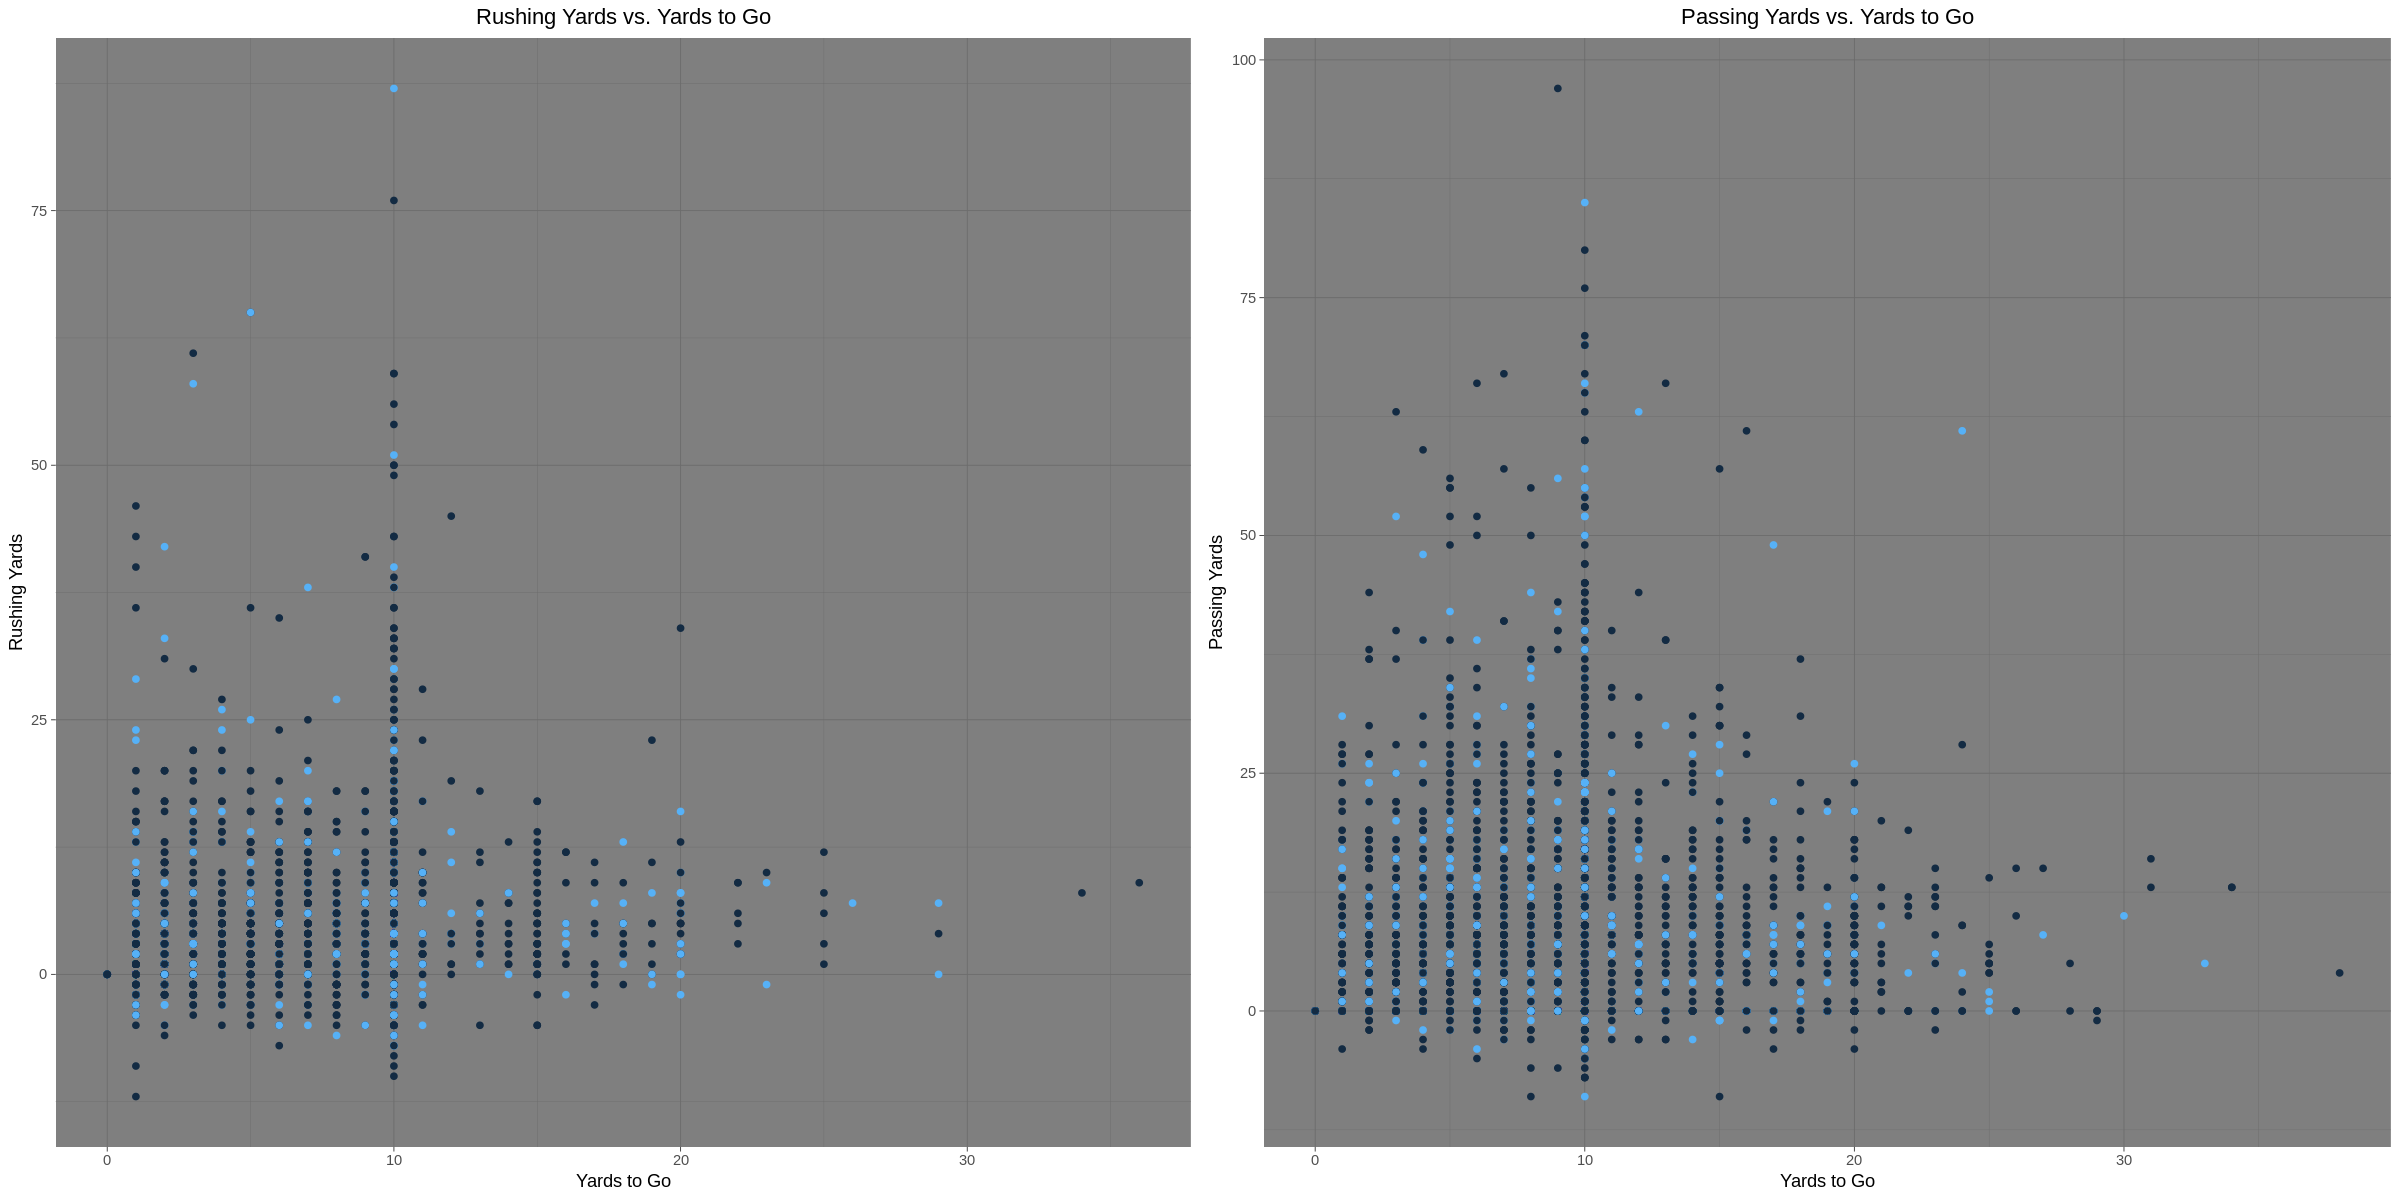

In [12]:
# plot all rush and pass data colored by whether or not they are my team
plot1 <- ggplot(pbp_cur_run,
  aes(x = ydstogo, y = rushing_yards, color = my_team)) +
    geom_point() +
    theme_dark() +
    xlab("Yards to Go") +
    ylab("Rushing Yards") +
    theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
    ggtitle("Rushing Yards vs. Yards to Go")

plot2 <- ggplot(pbp_cur_pass,
    aes(x = ydstogo, y = passing_yards, color = my_team)) +
      geom_point() +
      theme_dark() +
      xlab("Yards to Go") +
    ylab("Passing Yards") +
      theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
      ggtitle("Passing Yards vs. Yards to Go")

grid.arrange(plot1, plot2, ncol = 2)

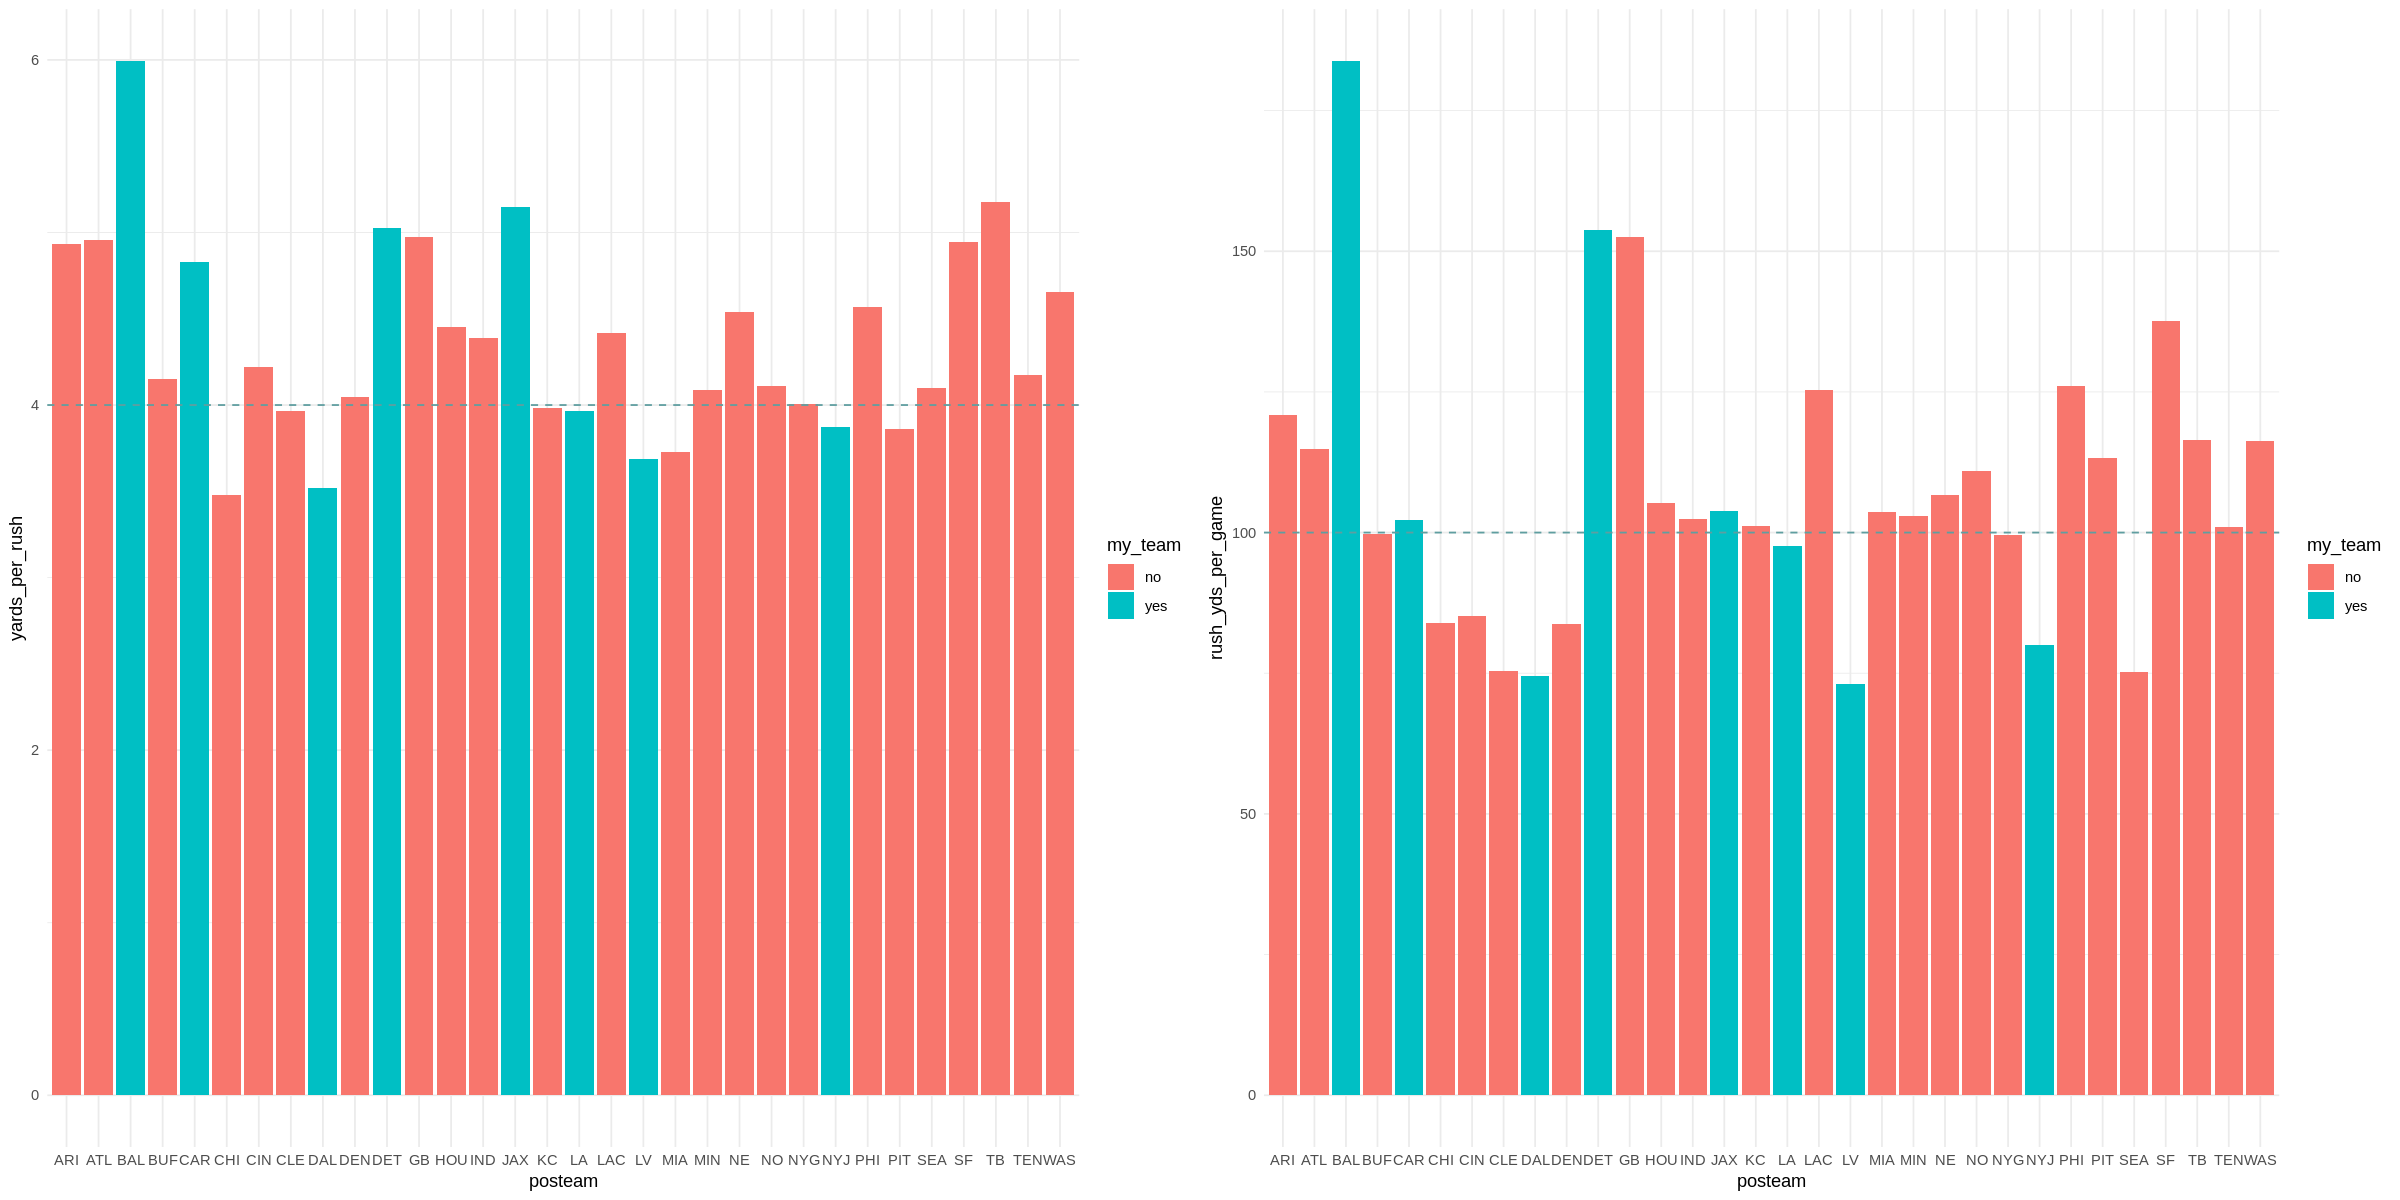

In [13]:
# plot yards per rush and yards per game, colored by whether or not they are my team
run_summary <- pbp_cur_run |>
  group_by(posteam) |>
  summarize(
    games = n_distinct(game_id),
    attempts = n(),
    attempts_per_game = (attempts/games),
    rush_yds_total = sum(rushing_yards),
    rush_yds_per_game = (rush_yds_total/games),
    yards_per_rush = mean(rushing_yards),
    my_team = ifelse(any(my_team == 1), "yes","no")
  ) |>
    arrange(-yards_per_rush)

# yards per rush
ypr <- ggplot(run_summary,
  aes(x = posteam, y = yards_per_rush, fill = my_team)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 4, linetype = 'dashed', color = 'cadetblue') +
    theme_minimal()

# rush yards per game
rpg <- ggplot(run_summary,
  aes(x = posteam, y = rush_yds_per_game, fill = my_team)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 100, linetype = 'dashed', color = 'cadetblue') +
    theme_minimal()

grid.arrange(ypr, rpg, ncol = 2)

In [14]:
# Run data - My Teams
run_summary |>
  filter(my_team == "yes") |>
    arrange(-rush_yds_per_game)

posteam,games,attempts,attempts_per_game,rush_yds_total,rush_yds_per_game,yards_per_rush,my_team
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
BAL,6,184,30.66667,1103,183.83333,5.994565,yes
DET,5,153,30.60000,769,153.80000,5.026144,yes
JAX,6,121,20.16667,623,103.83333,5.148760,yes
CAR,6,127,21.16667,613,102.16667,4.826772,yes
LA,5,123,24.60000,488,97.60000,3.967480,yes
NYJ,6,124,20.66667,480,80.00000,3.870968,yes
DAL,6,127,21.16667,447,74.50000,3.519685,yes
LV,6,119,19.83333,439,73.16667,3.689076,yes


### Passing Analysis

In [15]:
# create passing summary
pass_summary <- pbp_cur_pass |>
  group_by(posteam) |>
  summarize(
  attempts = n(),
  games = n_distinct(game_id),
  attempts_per_game = (attempts/games),
  pass_yds_total = sum(passing_yards),
  pass_yds_per_game = (pass_yds_total/games),
  yards_per_pass = mean(passing_yards),
  my_team = ifelse(any(my_team) == 1, "yes", "no")
  )

Warning message:
“There were 32 warnings in `summarize()`.
The first warning was:
ℹ In argument: `my_team = ifelse(any(my_team) == 1, "yes", "no")`.
ℹ In group 1: `posteam = "ARI"`.
Caused by warning in `any()`:
! coercing argument of type 'double' to logical
ℹ Run `dplyr::last_dplyr_warnings()` to see the 31 remaining warnings.”


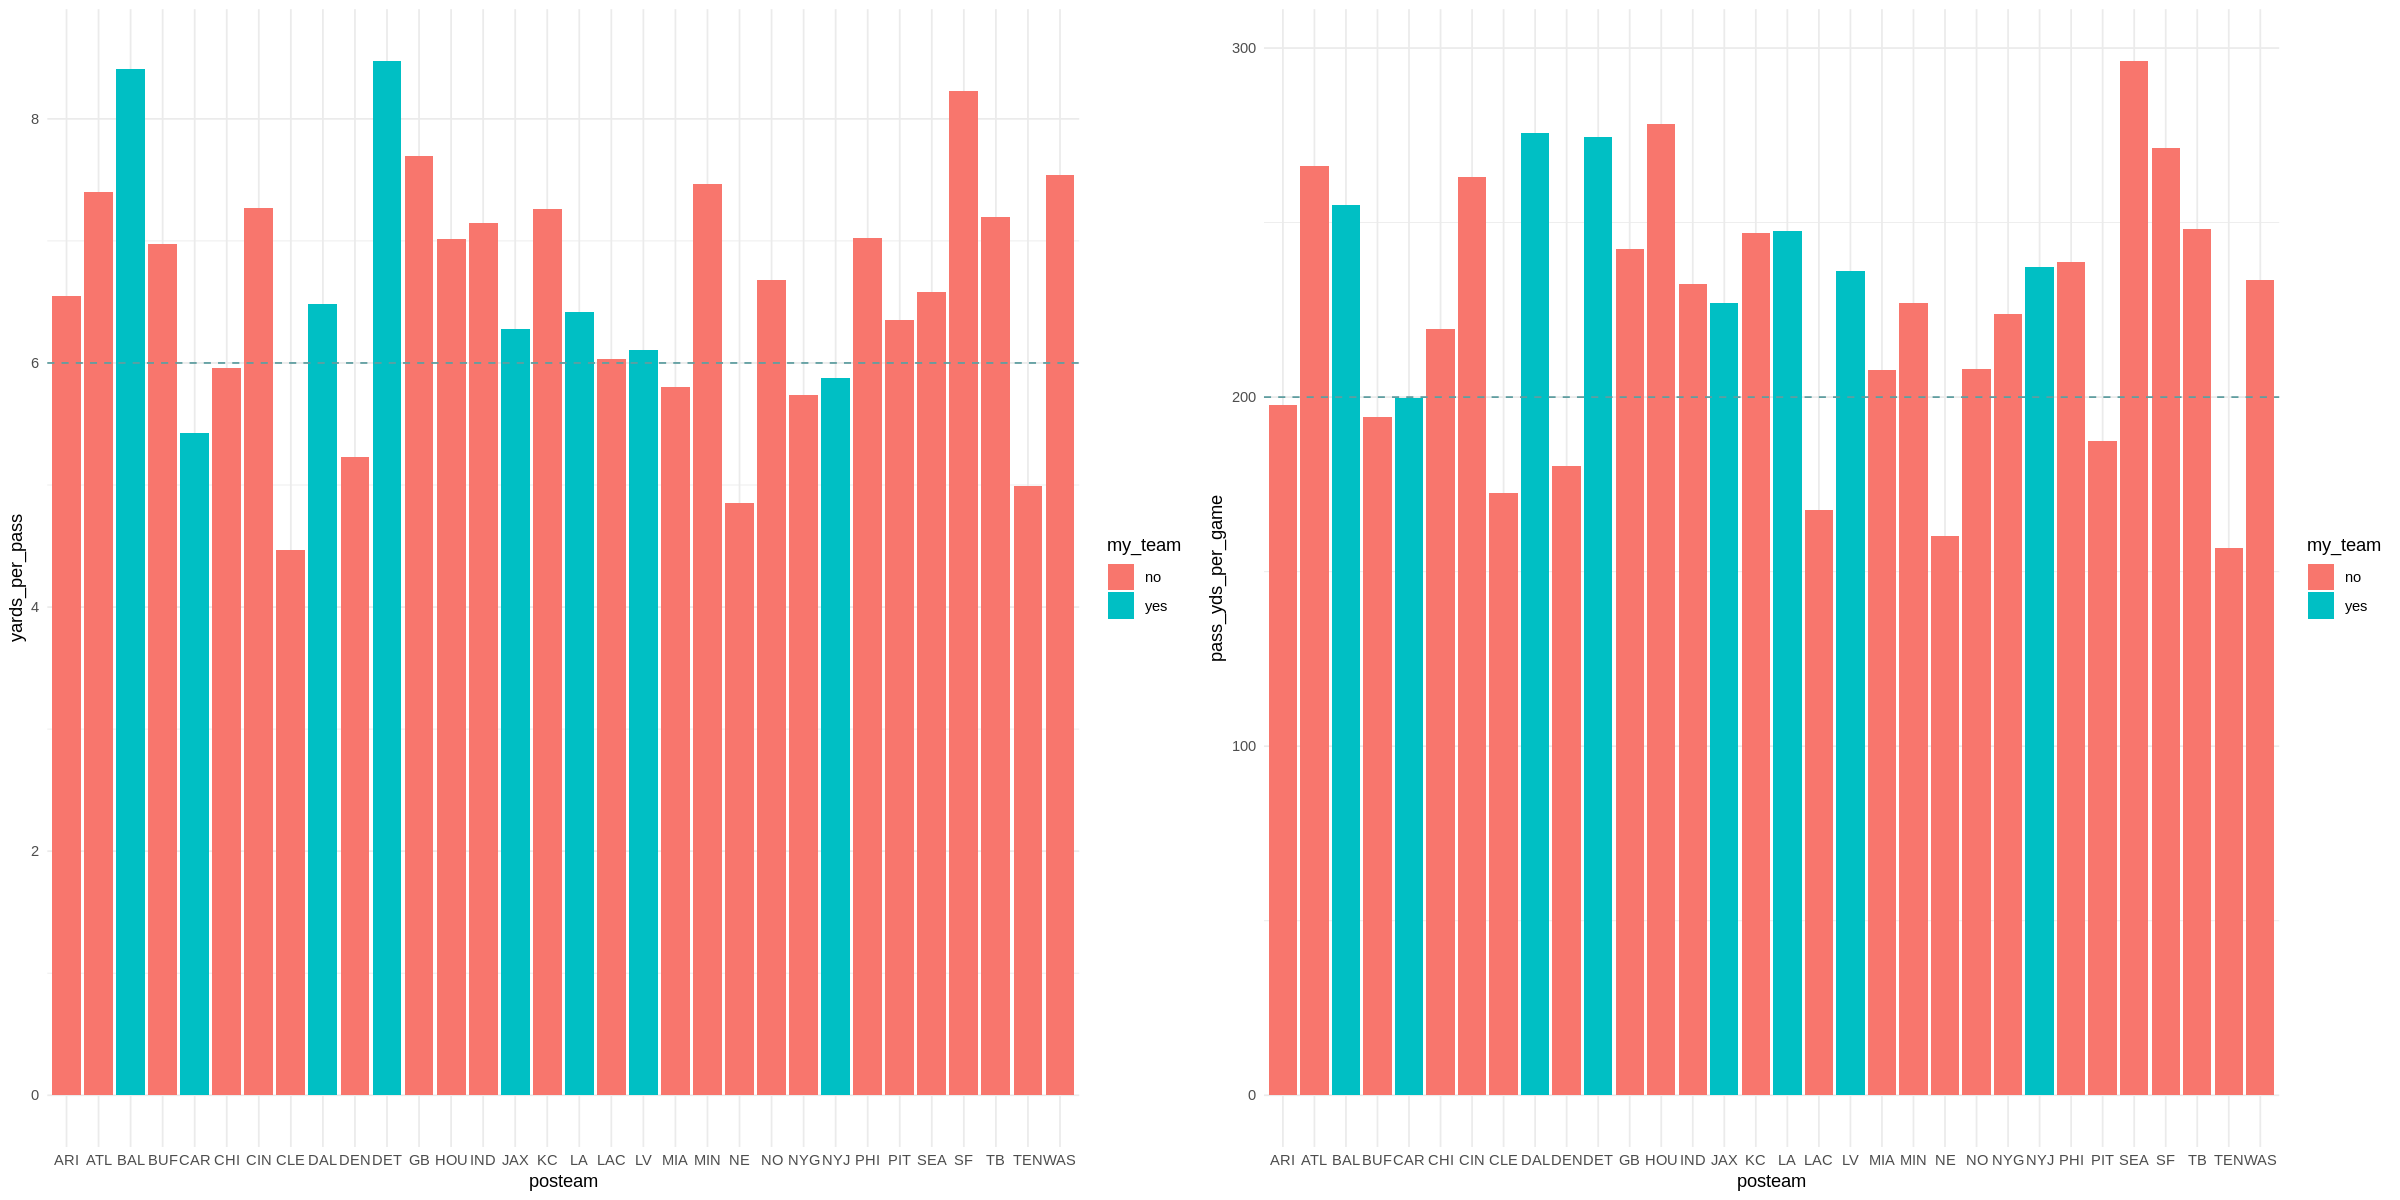

In [16]:
# bar chart of yards/pass and pass yds/game

# yards/pass
ypp <- ggplot(pass_summary,
  aes(x = posteam, y = yards_per_pass, fill = my_team)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 6, linetype = 'dashed', color = 'cadetblue') +
    theme_minimal()

# pass yds/game
pyg <- ggplot(pass_summary,
  aes(x = posteam, y = pass_yds_per_game, fill = my_team)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 200, linetype = 'dashed', color = 'cadetblue') +
    theme_minimal()

grid.arrange(ypp, pyg, ncol = 2)

In [17]:
# Pass Data - My Teams
pass_summary |>
  filter(my_team == "yes") |>
  arrange(-yards_per_pass)

posteam,attempts,games,attempts_per_game,pass_yds_total,pass_yds_per_game,yards_per_pass,my_team
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DET,162,5,32.40000,1373,274.6000,8.475309,yes
BAL,182,6,30.33333,1530,255.0000,8.406593,yes
DAL,255,6,42.50000,1654,275.6667,6.486275,yes
LA,193,5,38.60000,1238,247.6000,6.414508,yes
JAX,217,6,36.16667,1362,227.0000,6.276498,yes
LV,232,6,38.66667,1417,236.1667,6.107759,yes
NYJ,242,6,40.33333,1423,237.1667,5.880165,yes
CAR,221,6,36.83333,1199,199.8333,5.425339,yes


### Defensive Data

In [18]:
# season data
season_data <- load_schedules(seasons = 2024)

# filter for my teams
season_data_my_teams <- season_data |>
  filter(home_team %in% my_teams | away_team %in% my_teams) |>
  drop_na(home_score)

# get wins, losses, pts, pts against, rush_against, pass_against, rush_attempts, pass_attempts
games <- c()
wins <- c()
losses <- c()
points <- c()
points_against <- c()
rush_against <- c()
rush_attempts_against <- c()
pass_against <- c()
pass_attempts_against <- c()

for (team in my_teams) {

  # drop na values and filter to current team
  cur_team_games <- season_data_my_teams |>
    drop_na(home_score) |>
    filter(home_team == team | away_team == team)

  # get wins
  ws <- sum((cur_team_games$home_team == team & (cur_team_games$home_score > cur_team_games$away_score) | cur_team_games$away_team == team & (cur_team_games$away_score > cur_team_games$home_score)))

  # get losses
  ls <- sum((cur_team_games$home_team == team & (cur_team_games$home_score < cur_team_games$away_score) | cur_team_games$away_team == team & (cur_team_games$away_score < cur_team_games$home_score)))

  # get games
  gms = ws + ls

  # get points scored
  pts <- sum(ifelse(cur_team_games$home_team == team, cur_team_games$home_score, cur_team_games$away_score))

  # get points against
  pts_ag <- sum(ifelse(cur_team_games$home_team == team, cur_team_games$away_score, cur_team_games$home_score))

  # append to lists
  games <- c(games, gms)
  wins <- c(wins, ws)
  losses <- c(losses, ls)
  points <- c(points, pts)
  points_against <- c(points_against, pts_ag)

}

defensive_data <- data.frame(my_teams, games, wins, losses, points, points_against)

In [19]:
# add ppg, papg, avg_pt_diff
defensive_data <- defensive_data |>
  mutate(
  ppg = points/games,
  papg = points_against/games,
  avg_pt_diff = (points - points_against)/games
  )

In [20]:
# view defensive data
defensive_data

my_teams,games,wins,losses,points,points_against,ppg,papg,avg_pt_diff
<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
BAL,6,4,2,177,149,29.50000,24.83333,4.6666667
NYJ,6,2,4,113,108,18.83333,18.00000,0.8333333
JAX,6,1,5,113,178,18.83333,29.66667,-10.8333333
DAL,6,3,3,126,168,21.00000,28.00000,-7.0000000
LV,6,2,4,109,163,18.16667,27.16667,-9.0000000
LA,5,1,4,94,139,18.80000,27.80000,-9.0000000
CAR,6,1,5,103,203,17.16667,33.83333,-16.6666667
DET,5,4,1,151,91,30.20000,18.20000,12.0000000


In [21]:
# get pass, rush, and total yards allowed
pass_yds_allowed <- c()
rush_yds_allowed <- c()
total_yds_allowed <- c()

# pass yards allowed
for (team in my_teams){

  games_list <- pbp_cur_pass |>
    filter(
      home_team == team | away_team == team,
      posteam != team
    )

  pya <- sum(games_list$passing_yards)

  pass_yds_allowed <- c(pass_yds_allowed, pya)
}

# rush yards allowed
for (team in my_teams){

  games_list <- pbp_cur_run |>
    filter(
      home_team == team | away_team == team,
      posteam != team
    )

  rya <- sum(games_list$rushing_yards)

  rush_yds_allowed <- c(rush_yds_allowed, rya)
}

defensive_data$pass_yds_allowed <- pass_yds_allowed
defensive_data$rush_yds_allowed <- rush_yds_allowed
defensive_data$total_yds_allowed <- (pass_yds_allowed + rush_yds_allowed)

In [22]:
# add rya_per_game and pya_per_game
defensive_data <- defensive_data |>
  mutate(
    rya_per_game = rush_yds_allowed/games,
    pya_per_game = pass_yds_allowed/games,
    ya_per_game = total_yds_allowed/games
  )

defensive_data |>
  arrange(-ppg)

my_teams,games,wins,losses,points,points_against,ppg,papg,avg_pt_diff,pass_yds_allowed,rush_yds_allowed,total_yds_allowed,rya_per_game,pya_per_game,ya_per_game
<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DET,5,4,1,151,91,30.20000,18.20000,12.0000000,1328,344,1672,68.80000,265.6000,334.4000
BAL,6,4,2,177,149,29.50000,24.83333,4.6666667,1789,308,2097,51.33333,298.1667,349.5000
DAL,6,3,3,126,168,21.00000,28.00000,-7.0000000,1359,816,2175,136.00000,226.5000,362.5000
NYJ,6,2,4,113,108,18.83333,18.00000,0.8333333,1021,667,1688,111.16667,170.1667,281.3333
JAX,6,1,5,113,178,18.83333,29.66667,-10.8333333,1744,547,2291,91.16667,290.6667,381.8333
LA,5,1,4,94,139,18.80000,27.80000,-9.0000000,1156,687,1843,137.40000,231.2000,368.6000
LV,6,2,4,109,163,18.16667,27.16667,-9.0000000,1237,743,1980,123.83333,206.1667,330.0000
CAR,6,1,5,103,203,17.16667,33.83333,-16.6666667,1387,860,2247,143.33333,231.1667,374.5000


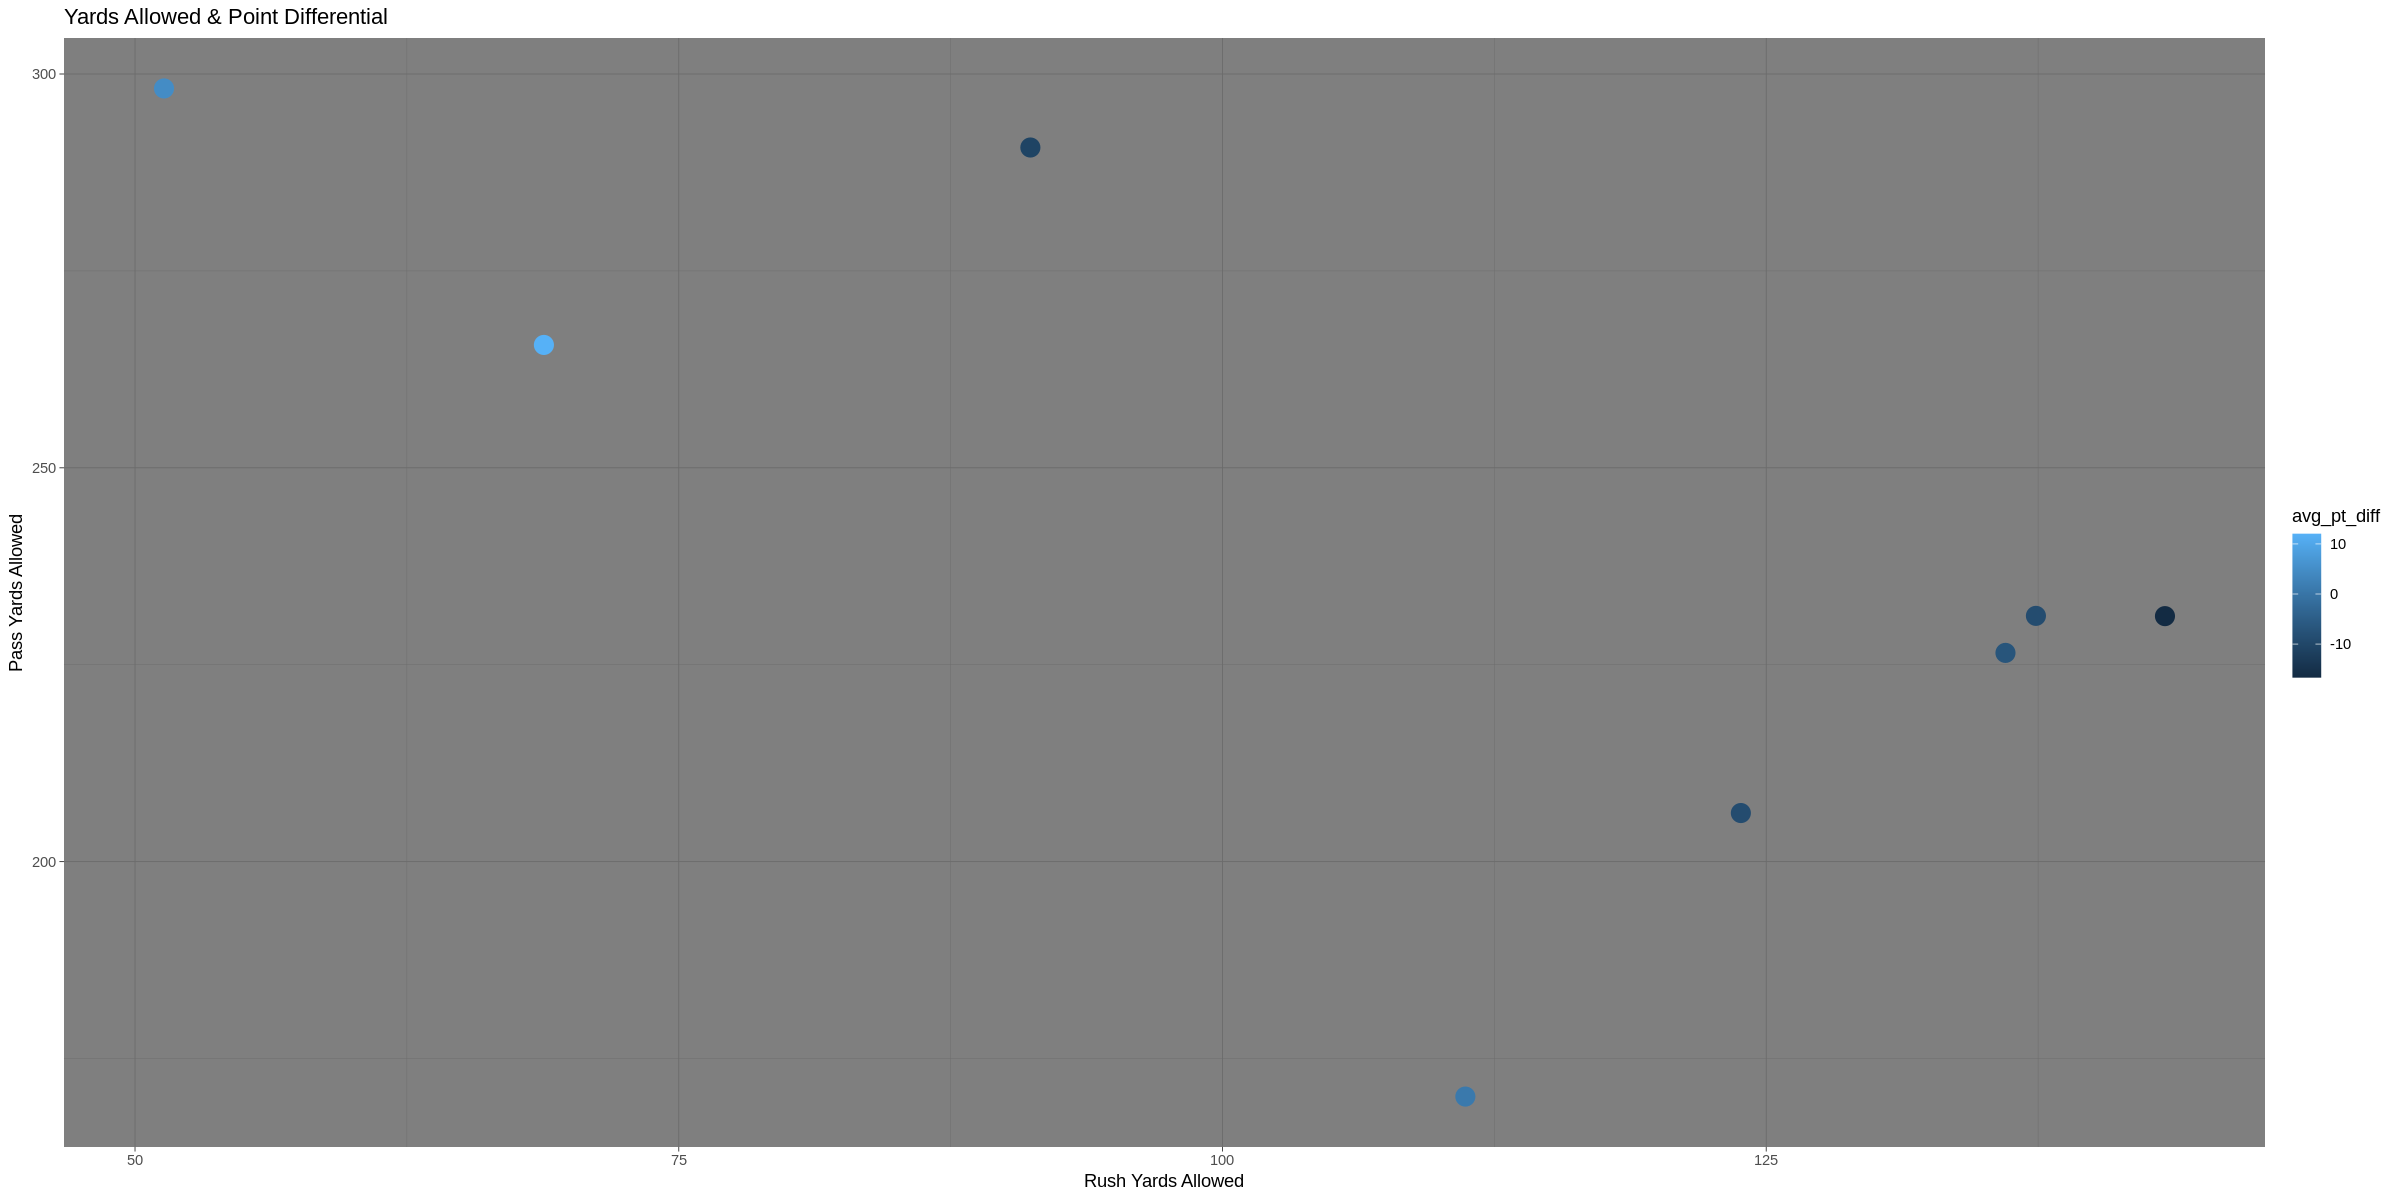

In [23]:
# plot rush yards allowed , pass yards allowed, and point diff
ggplot(defensive_data, aes(x = rya_per_game, pya_per_game, color = avg_pt_diff)) +
  geom_point(size = 5) +
  theme_dark() +
  labs(title = "Yards Allowed & Point Differential", x = "Rush Yards Allowed", y = "Pass Yards Allowed")

## Part 3: Build SLR Models

`geom_smooth()` using formula = 'y ~ x'


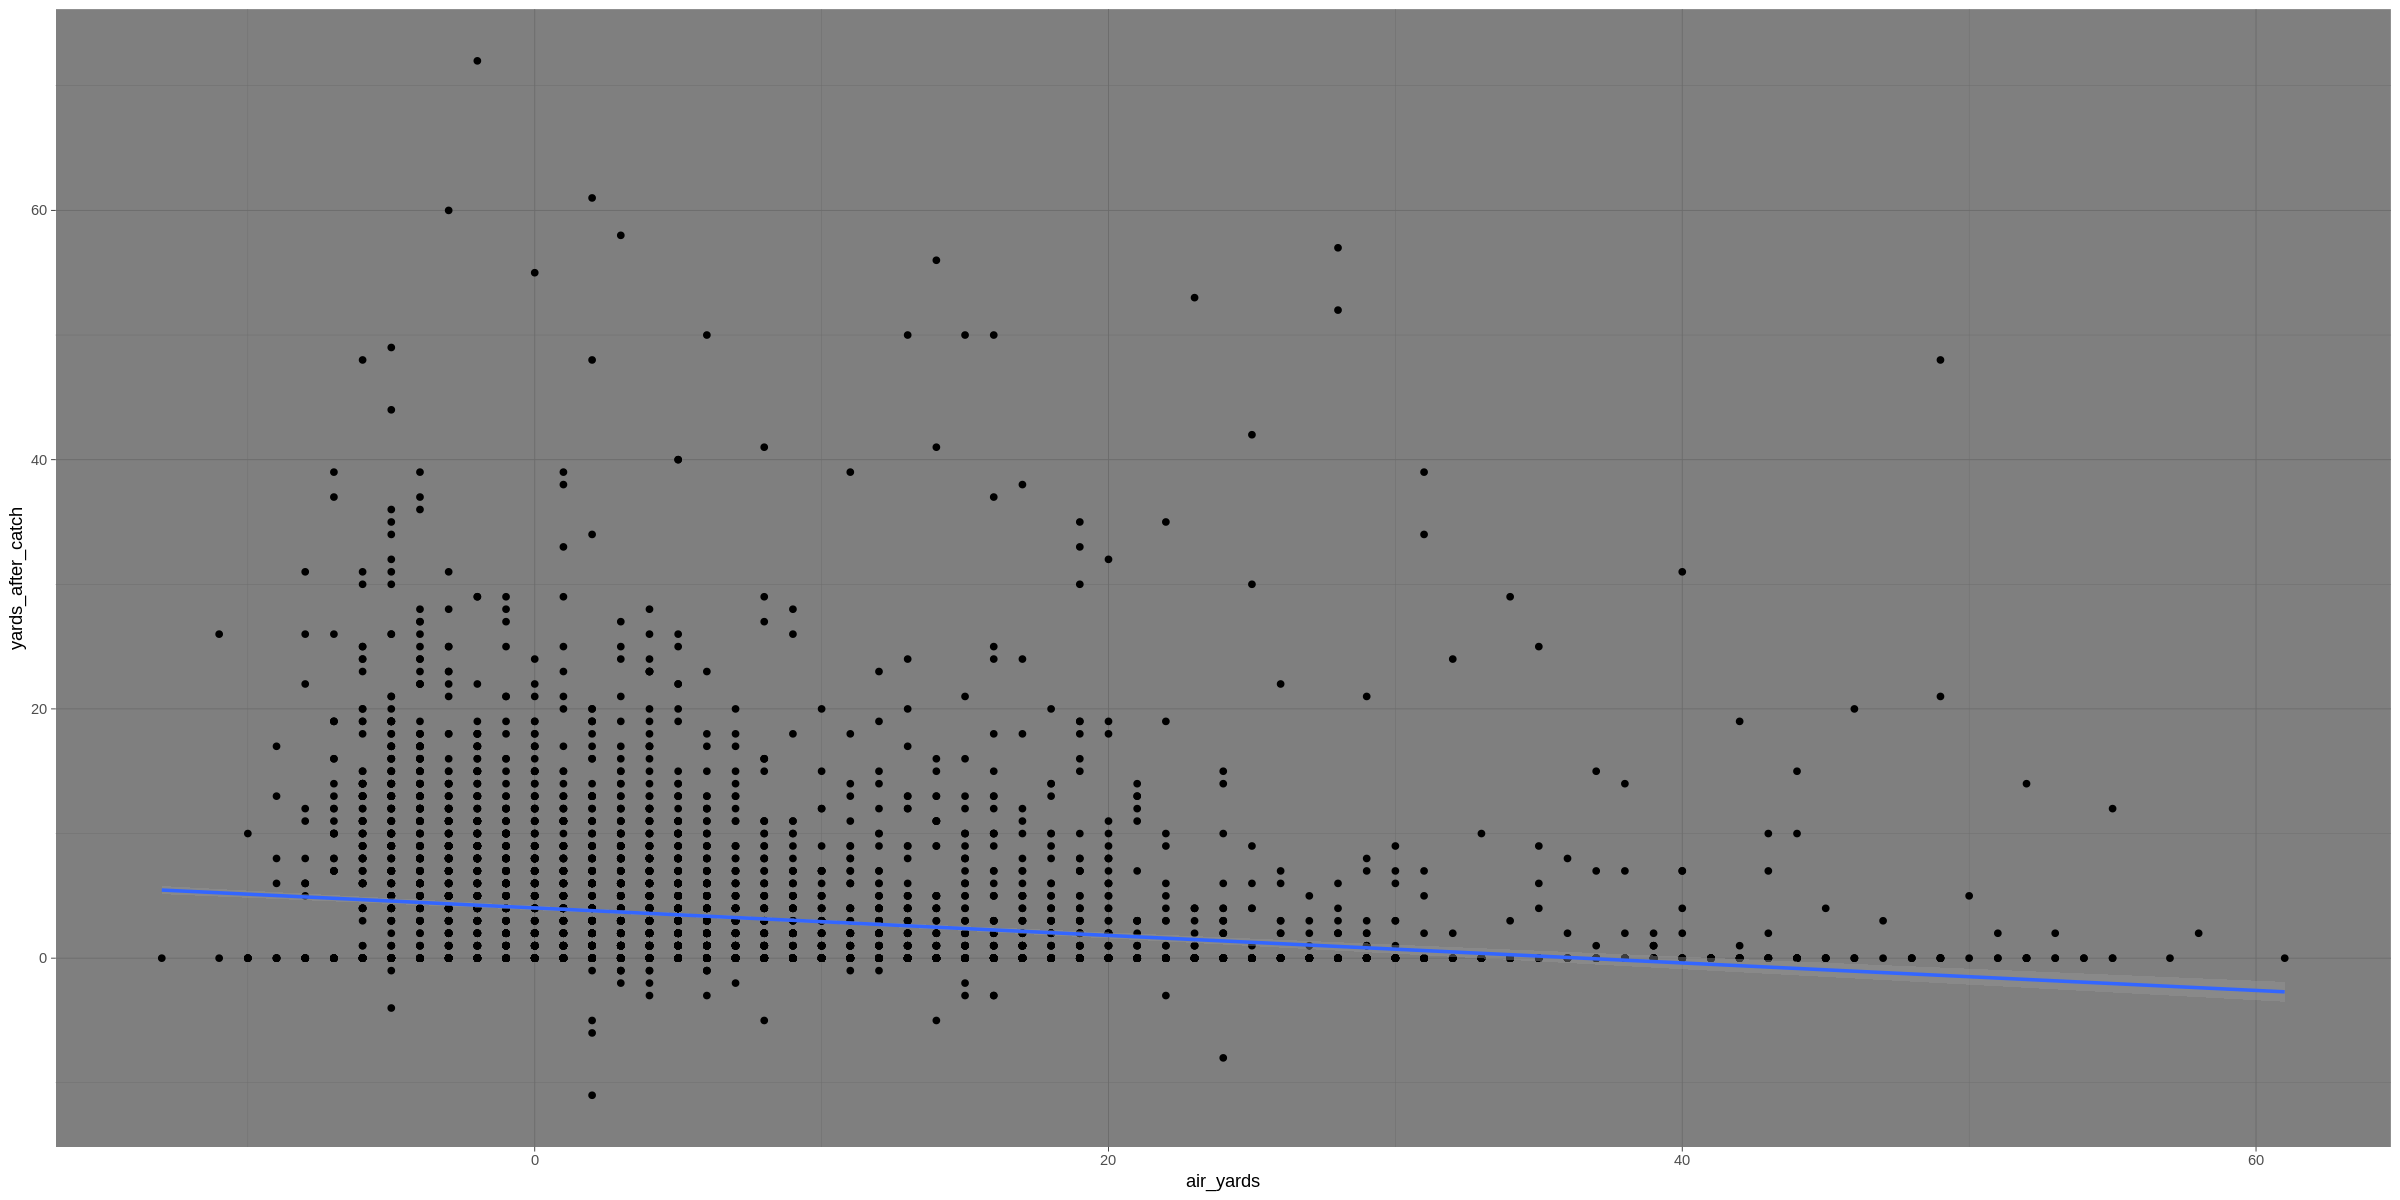

In [24]:
# plot yards after catch based on air_yards
plot1 <- pbp_cur_pass |>
  mutate(
      yards_after_catch = ifelse(is.na(yards_after_catch),0,yards_after_catch),
      air_yards = ifelse(is.na(air_yards),0,air_yards)
  ) |>
  ggplot() +
  aes(x = air_yards, y = yards_after_catch) +
  geom_point() +
  geom_smooth(method = 'lm') +
  theme_dark()

plot1

`geom_smooth()` using formula = 'y ~ x'


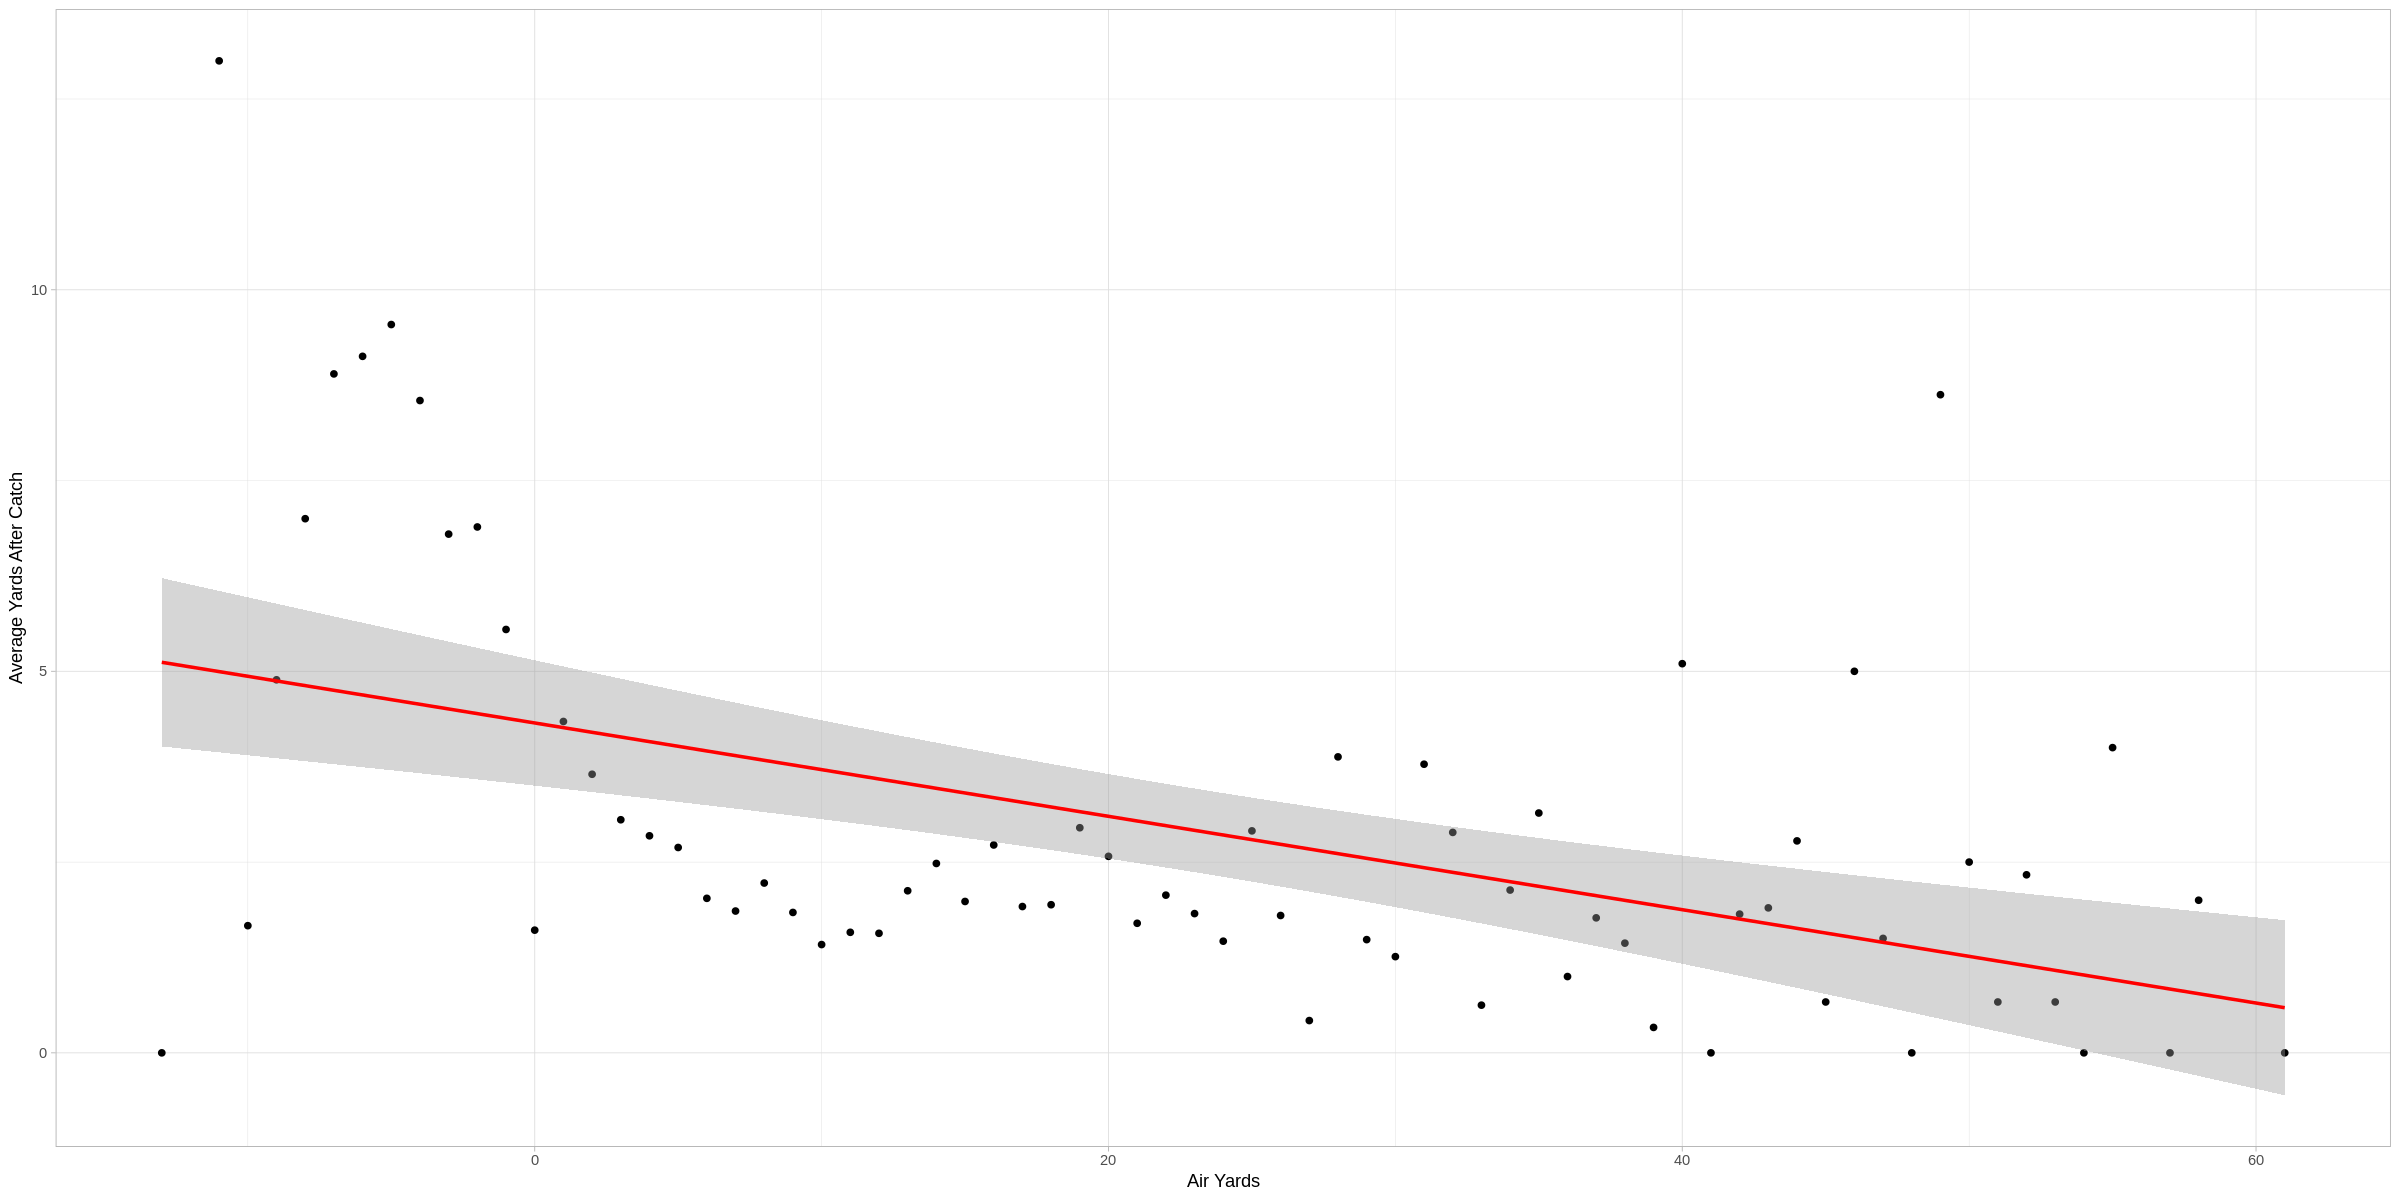

In [25]:
# bin data

pbp_cur_pass <- pbp_cur_pass |>
  mutate(
      yards_after_catch = ifelse(is.na(yards_after_catch),0,yards_after_catch),
      air_yards = ifelse(is.na(air_yards),0,air_yards)
  )

pbp_yac_avg <- pbp_cur_pass |>
  group_by(air_yards) |>
  summarize(avg_yac = mean(yards_after_catch))

# plot binned data
ggplot(pbp_yac_avg, aes(x = air_yards, y = avg_yac)) +
  geom_point() +
    theme_light() +
    geom_smooth(method = 'lm', color = 'red') +
    labs(x = "Air Yards", y = "Average Yards After Catch")

In [26]:
# build and fit linear model

yac_model <- lm(yards_after_catch ~ 1 + air_yards, data = pbp_cur_pass)

summary(yac_model)


Call:
lm(formula = yards_after_catch ~ 1 + air_yards, data = pbp_cur_pass)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.811  -3.480  -2.045   1.286  67.748 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.03147    0.09057   44.51   <2e-16 ***
air_yards   -0.11037    0.00741  -14.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.927 on 6389 degrees of freedom
Multiple R-squared:  0.03356,	Adjusted R-squared:  0.03341 
F-statistic: 221.9 on 1 and 6389 DF,  p-value: < 2.2e-16


In [27]:
# save residuals as yacoe

pbp_cur_pass <- pbp_cur_pass |>
  mutate(
  yacoe = resid(yac_model)
  )

In [28]:
# tibble for yacoe, total yac, and yac per catch

yacoe_data_team <- pbp_cur_pass |>
  group_by(posteam) |>
  summarize(
  attempts = n(),
  yacoe_total = sum(yacoe),
  avg_yacoe = mean(yacoe),
  yac_total = sum(yards_after_catch),
  avg_yac = mean(yards_after_catch),
  avg_air_yards = mean(air_yards),
  my_team = ifelse(any(posteam %in% my_teams), "yes", "no")
  ) |>
    arrange(-avg_yacoe)

yacoe_data_player <- pbp_cur_pass |>
  group_by(posteam, receiver_player_id, receiver_player_name) |>
  drop_na(receiver_player_id) |>
  summarize(
  attempts = n(),
  yacoe_total = sum(yacoe),
  avg_yacoe = mean(yacoe),
  yac_total = sum(yards_after_catch),
  avg_yac = mean(yards_after_catch),
  avg_air_yards = mean(air_yards),
  my_team = ifelse(any(posteam %in% my_teams), "yes", "no")
  ) |>
    arrange(-avg_yacoe)

`summarise()` has grouped output by 'posteam', 'receiver_player_id'. You can
override using the `.groups` argument.


In [29]:
# look at team data
print(yacoe_data_team)

# A tibble: 32 × 8
   posteam attempts yacoe_total avg_yacoe yac_total avg_yac avg_air_yards
   <chr>      <int>       <dbl>     <dbl>     <dbl>   <dbl>         <dbl>
 1 DET          162       237.      1.47        770    4.75          6.74
 2 BAL          182       239.      1.32        824    4.53          7.42
 3 KC           170       193.      1.14        786    4.62          4.94
 4 TB           207       220.      1.06        938    4.53          5.09
 5 GB           189       163.      0.862       757    4.01          8.05
 6 BUF          167       128.      0.765       648    3.88          8.31
 7 WAS          186        91.9     0.494       707    3.80          6.56
 8 PHI          170        67.1     0.395       618    3.64          7.16
 9 ATL          216        75.6     0.350       781    3.62          6.94
10 MIA          179        27.4     0.153       616    3.44          6.73
# ℹ 22 more rows
# ℹ 1 more variable: my_team <chr>


In [30]:
# look at player data
yacoe_data_player

posteam,receiver_player_id,receiver_player_name,attempts,yacoe_total,avg_yacoe,yac_total,avg_yac,avg_air_yards,my_team
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TB,00-0038824,R.Miller,1,34.078904,34.078904,38,38.000000,1.0000000,no
JAX,00-0038555,T.Bigsby,1,26.637422,26.637422,31,31.000000,-3.0000000,yes
ATL,00-0034854,K.Hodge,2,39.365217,19.682609,45,22.500000,11.0000000,no
MIA,00-0036620,D.Eskridge,1,14.403349,14.403349,17,17.000000,13.0000000,no
TB,00-0038951,S.Tucker,4,50.315617,12.578904,66,16.500000,1.0000000,no
NYG,00-0038396,E.Gray,5,52.076741,10.415348,74,14.800000,-3.2000000,no
WAS,00-0033699,A.Ekeler,16,155.185426,9.699089,223,13.937500,-1.8750000,no
LA,00-0039738,B.Corum,1,9.306311,9.306311,14,14.000000,-6.0000000,yes
MIN,00-0035311,M.Gaskin,1,8.747793,8.747793,13,13.000000,-2.0000000,no


In [31]:
# just my teams
yacoe_data_team |>
  filter(my_team == "yes")

posteam,attempts,yacoe_total,avg_yacoe,yac_total,avg_yac,avg_air_yards,my_team
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DET,162,237.42699,1.4655987,770,4.753086,6.740741,yes
BAL,182,239.38360,1.3152945,824,4.527473,7.423077,yes
DAL,255,-29.97562,-0.1175514,790,3.098039,7.392157,yes
LV,232,-33.48378,-0.1443266,742,3.198276,6.241379,yes
NYJ,242,-81.32658,-0.3360602,722,2.983471,6.450413,yes
LA,193,-72.04623,-0.3732965,561,2.906736,6.808290,yes
JAX,217,-94.83028,-0.4370059,581,2.677419,8.308756,yes
CAR,221,-165.63246,-0.7494681,558,2.524887,6.859729,yes


In [32]:
# just my teams - players
yacoe_data_player |>
  filter(my_team == 'yes')

posteam,receiver_player_id,receiver_player_name,attempts,yacoe_total,avg_yacoe,yac_total,avg_yac,avg_air_yards,my_team
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
JAX,00-0038555,T.Bigsby,1,26.637422,26.637422,31,31.000000,-3.0000000,yes
LA,00-0039738,B.Corum,1,9.306311,9.306311,14,14.000000,-6.0000000,yes
BAL,00-0038046,C.Kolar,6,41.777872,6.962979,61,10.166667,7.5000000,yes
DET,00-0035685,D.Montgomery,10,58.133485,5.813348,99,9.900000,-0.5000000,yes
DET,00-0039065,S.LaPorta,15,76.364307,5.090954,129,8.600000,4.7333333,yes
DAL,00-0038738,H.Luepke,8,39.507531,4.938441,69,8.625000,3.1250000,yes
BAL,00-0034975,J.Hill,21,96.904392,4.614495,183,8.714286,-0.6190476,yes
DET,00-0037240,J.Williams,29,113.339359,3.908254,185,6.379310,14.1379310,yes
LV,00-0034972,A.Mattison,18,65.771384,3.653966,139,7.722222,-0.3333333,yes


`geom_smooth()` using formula = 'y ~ x'


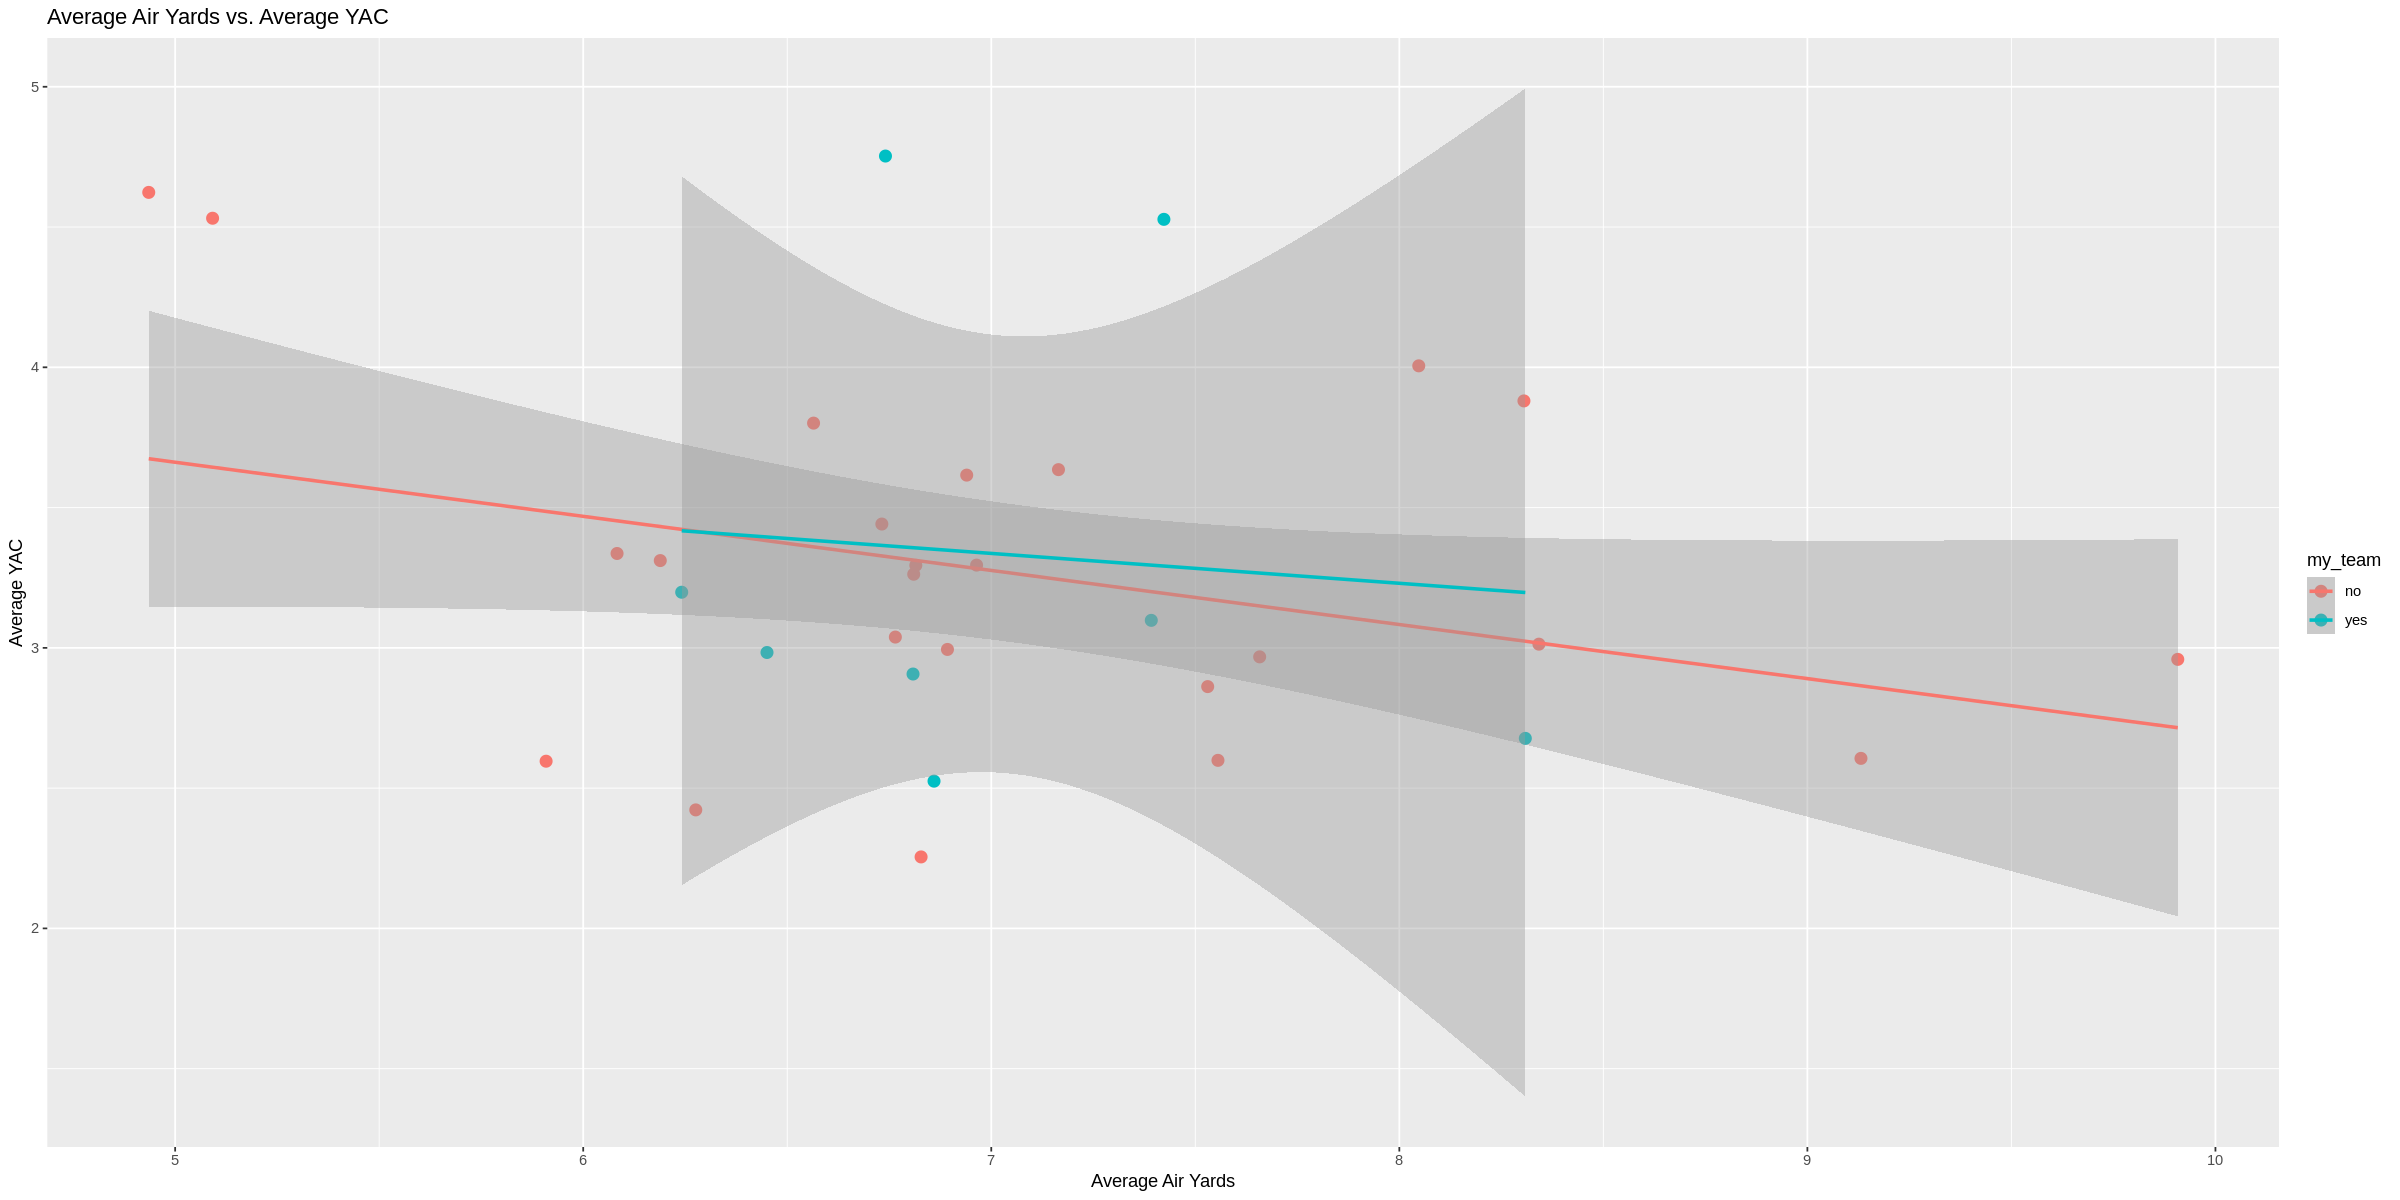

In [33]:
# plot average air yards and avg yac
ggplot(yacoe_data_team, aes(x = avg_air_yards, y = avg_yac, color = my_team)) +
  geom_point(size = 3) +
  theme_gray() +
  geom_smooth(method = 'lm') +
  labs(title = "Average Air Yards vs. Average YAC", x = "Average Air Yards", y = "Average YAC")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation:
colour.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


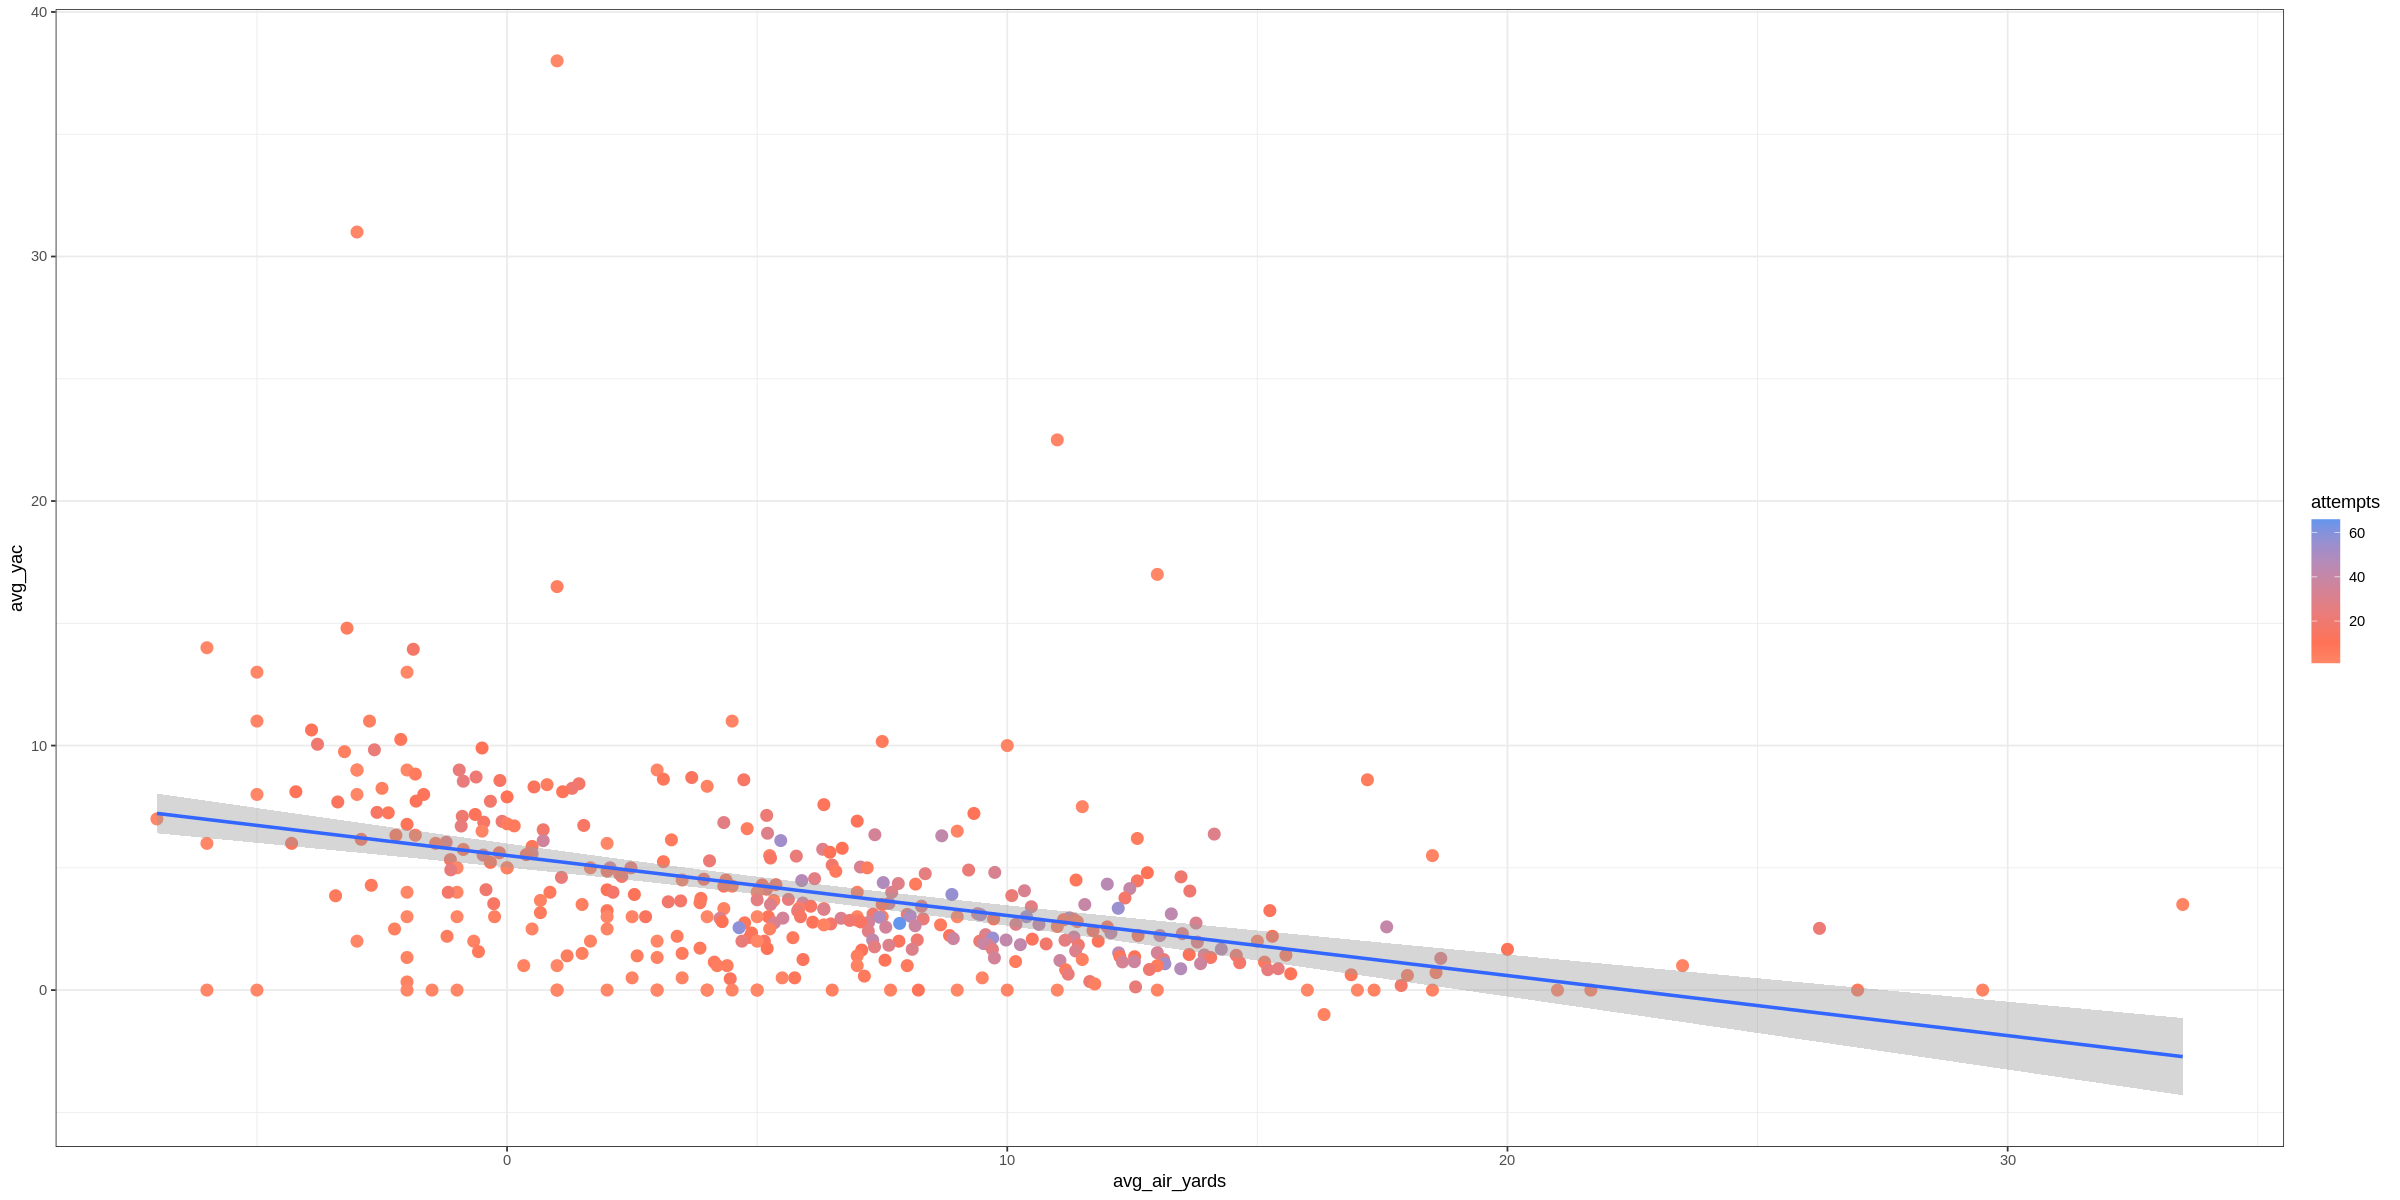

In [34]:
# plot average air yards vs. average yac colored by number of attempts
ggplot(yacoe_data_player, aes(x = avg_air_yards, y = avg_yac, color = attempts)) +
  geom_point(size = 3) +
  scale_color_gradient2(low = "bisque", mid = "coral1", high = "cornflowerblue", midpoint = 10) +
  theme_bw() +
  geom_smooth(method = 'lm')

### SLM for Each Team

In [35]:
# get week 3 opponents for my teams
opponent_week_3 <- c()

my_teams_wk_3 <- season_data |>
  filter((home_team %in% my_teams | away_team %in% my_teams) & week == 3)

for (team in my_teams){
  for (i in 1:nrow(my_teams_wk_3)){
    game <- my_teams_wk_3[i,]
    if (game$home_team == team){
      opp <- game$away_team
    } else if (game$away_team == team){
      opp <- game$home_team
    }
  }
  opponent_week_3 <- c(opponent_week_3, opp)
}

print(opponent_week_3)

[1] "DAL" "NE"  "BUF" "BAL" "CAR" "SF"  "LV"  "ARI"


In [36]:
# function for creating model based off of week 3 opponent
predict_wk3 <- function(team, opponent){
  matchup_hist <- pbp_old |>
    filter((home_team == team & away_team == opponent) | (home_team == opponent & away_team == team))

  if (nrow(matchup_hist) == 0){
    return(cat("No data available for the past 3 years because ", team, " and ", opponent, " have not played each other."))
  }

  team_data <- matchup_hist |>
    filter(posteam == team) |>
    filter(play_type == "pass") |>
    mutate(
    air_yards = ifelse((is.na(air_yards)),0, air_yards),
    yards_after_catch = ifelse((is.na(yards_after_catch)),0, yards_after_catch))

  plot <- ggplot(team_data, aes(x = air_yards, y = yards_after_catch)) +
    geom_point(size = 3) +
    theme_dark() +
      theme(plot.title = element_text(hjust = 0.5)) +
      labs(title = cat(team, " vs. ", opponent)) +
      geom_smooth(method = "lm")

  return(plot)
}

In [37]:
# function for creating model based off of week 3 opponent
predict_all <- function(team){
  matchup_hist <- pbp_old |>
    filter(home_team == team |away_team == team)

  team_data <- matchup_hist |>
    filter(posteam == team) |>
    filter(play_type == "pass") |>
    mutate(
    air_yards = ifelse((is.na(air_yards)),0, air_yards),
    yards_after_catch = ifelse((is.na(yards_after_catch)),0, yards_after_catch))

  plot <- ggplot(team_data, aes(x = air_yards, y = yards_after_catch)) +
    geom_point(size = 3) +
    theme_dark() +
      geom_smooth(method = "lm")

  return(plot)
}

## Part 4: Interpretation and Discussion

### Baltimore
Baltimore has not played Dallas since 2020, so this data may not be the most reliable for making adjustments, especially considering how few data points there are.  However, our model would predict more yards after catch for deeper passes, but that trend doesn't stand out just looking at the data.

BAL  vs.  DAL

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


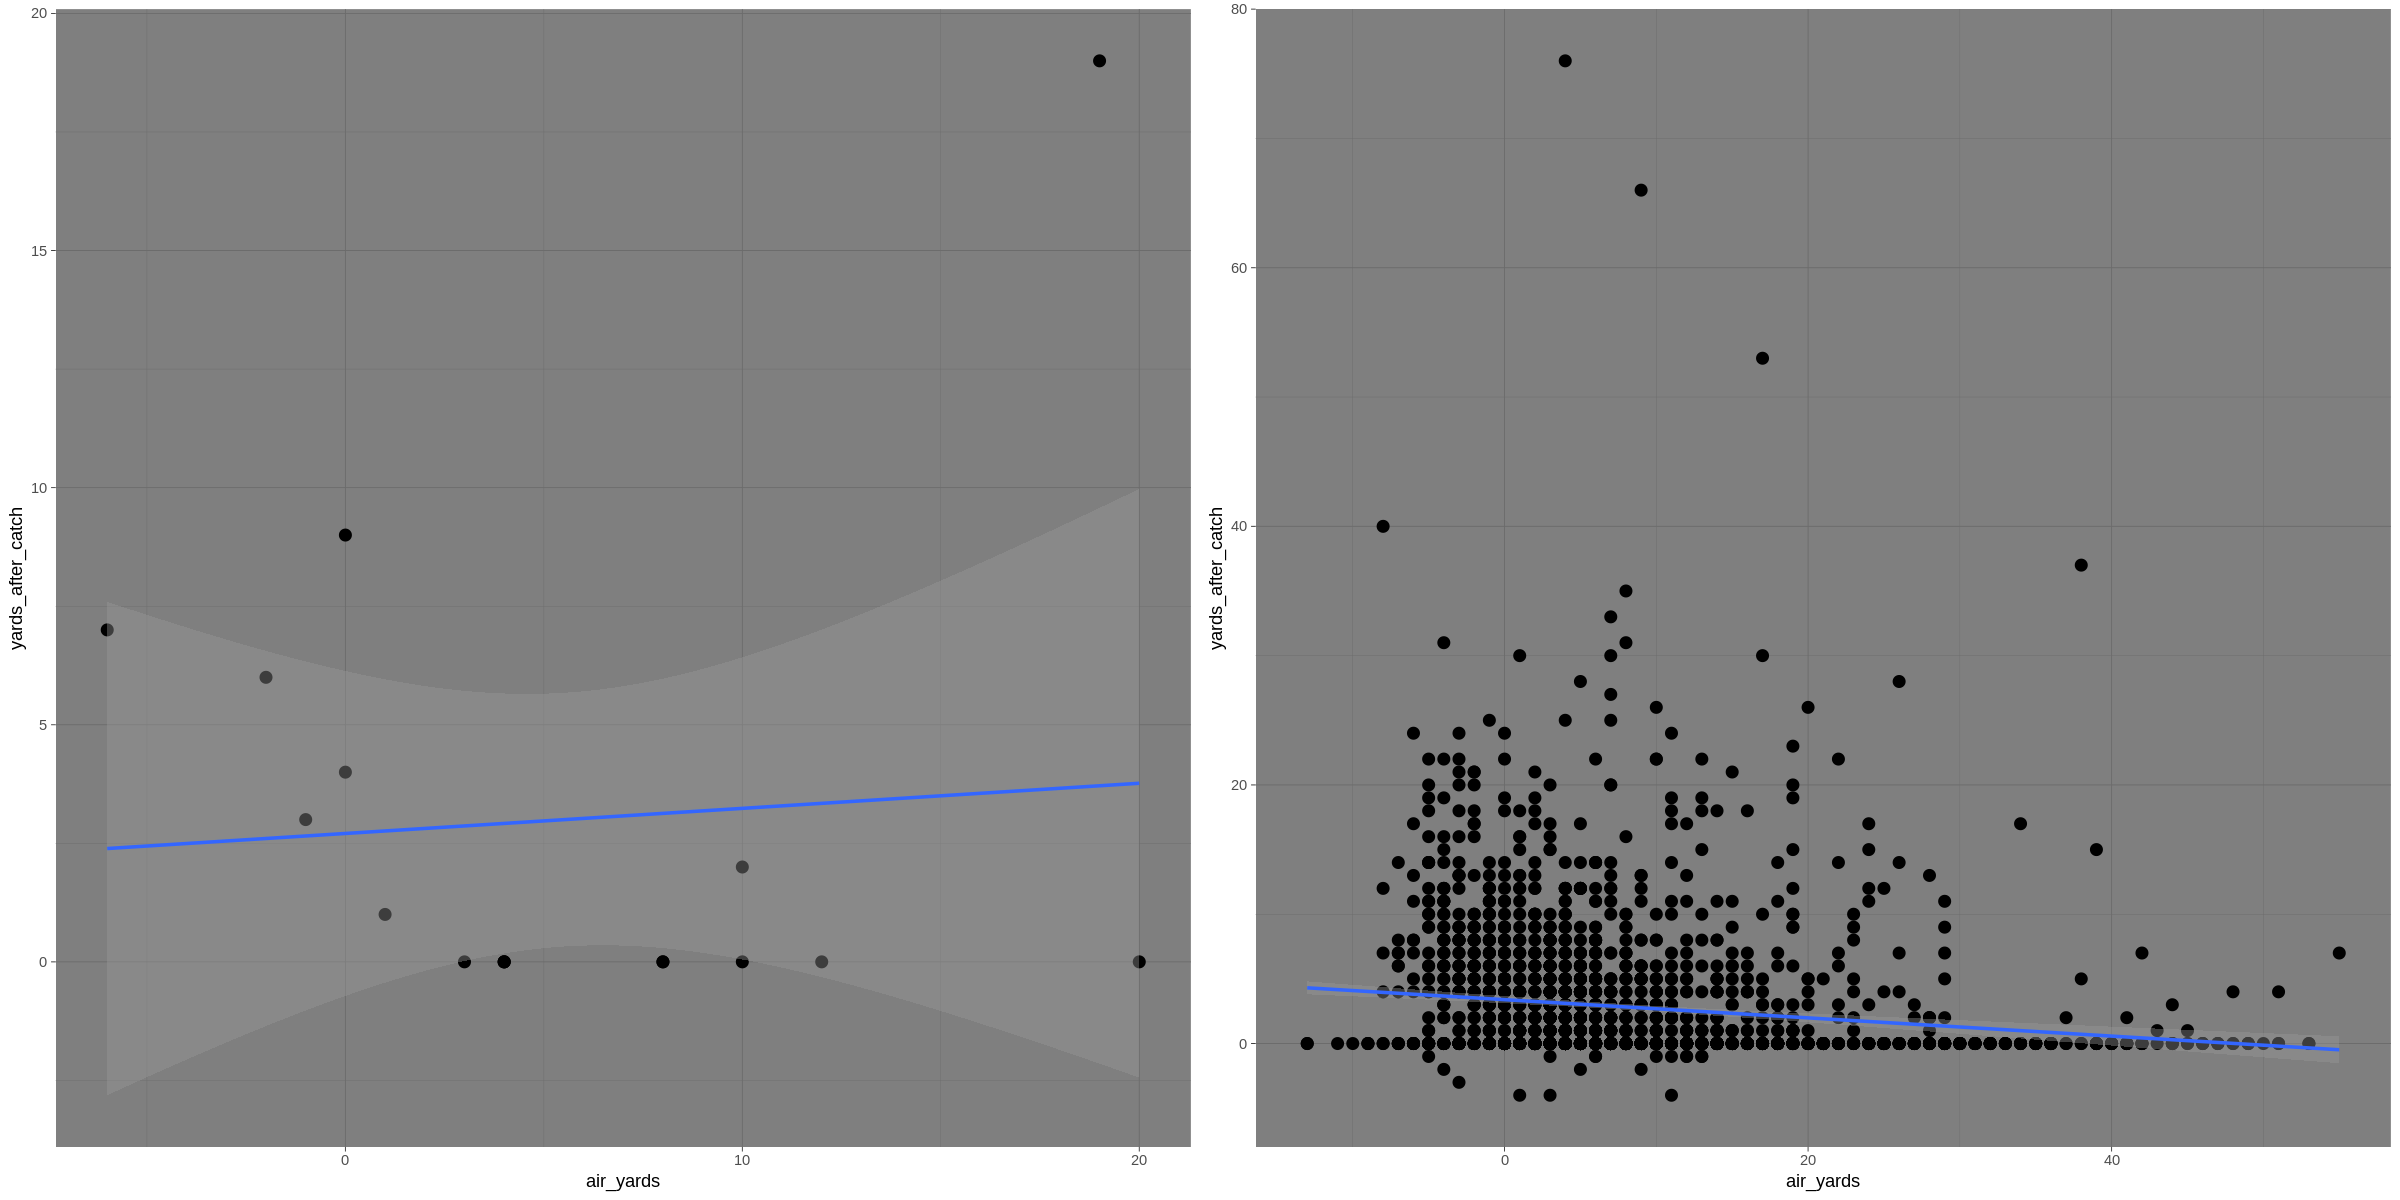

In [38]:
# Baltimore
plot1 <- predict_wk3(my_teams[1], opponent_week_3[1])
plot2 <- predict_all(my_teams[1])

grid.arrange(plot1, plot2, ncol = 2)

### New York Jets
The Jets trend of yards of catch against the Patriots looks to fit their general trend against all opponents.

NYJ  vs.  NE

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


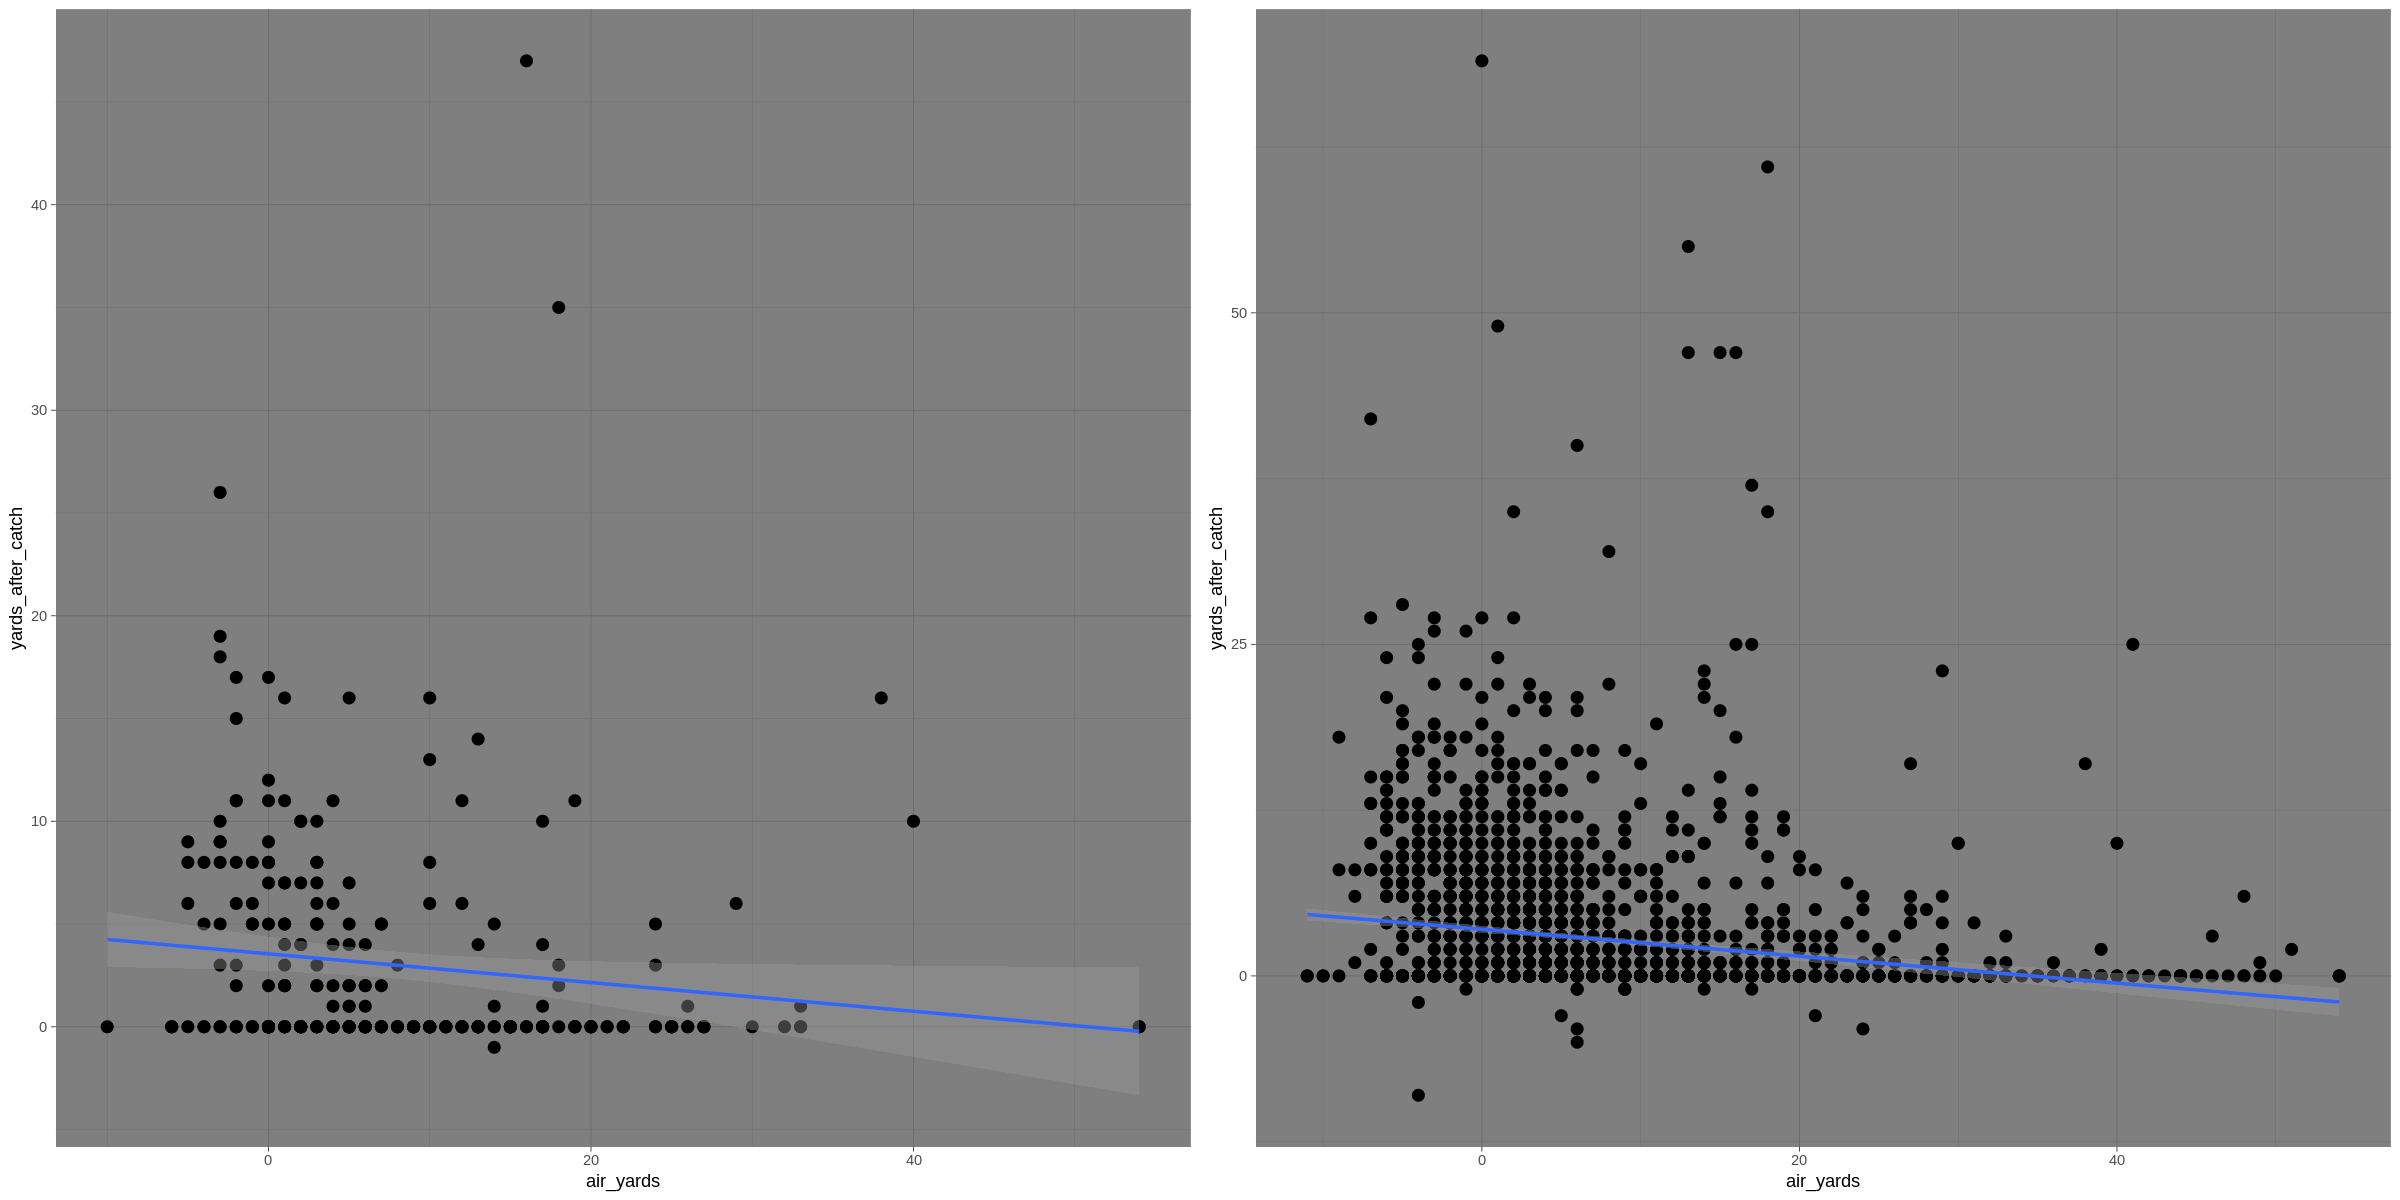

In [39]:
# Jets
plot1 <- predict_wk3(my_teams[2], opponent_week_3[2])
plot2 <- predict_all(my_teams[2])

grid.arrange(plot1, plot2, ncol = 2)

### Jacksonville
The Jaguars trend against Buffalo is very similar to its trend against all teams, but has a slightly lower starting point (x = 0).

JAX  vs.  BUF

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


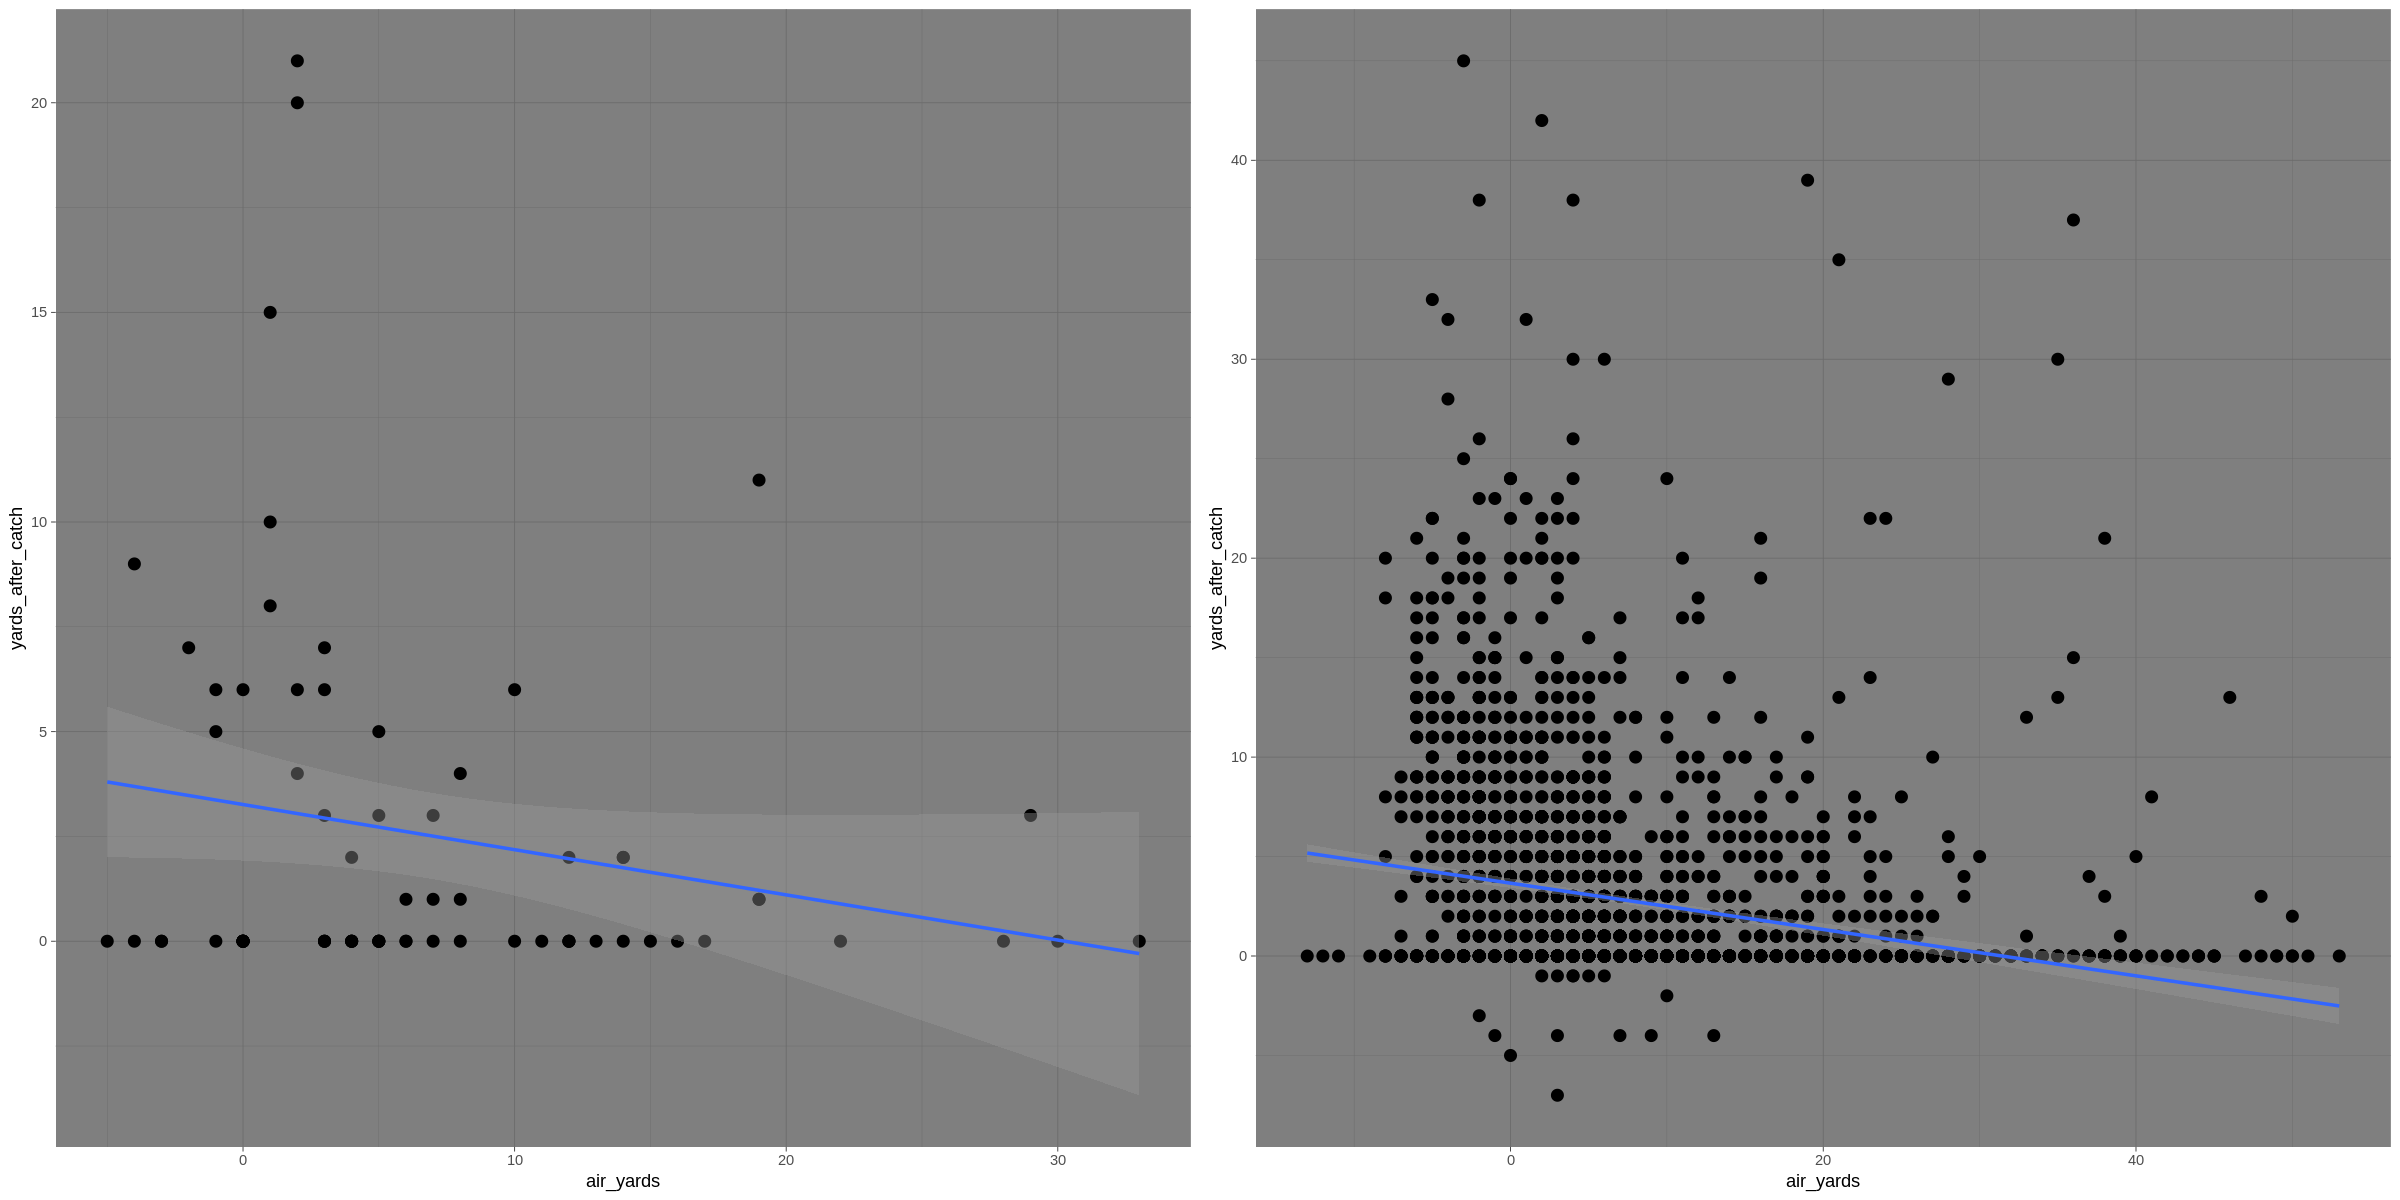

In [40]:
# Jacksonville
plot1 <- predict_wk3(my_teams[3], opponent_week_3[3])
plot2 <- predict_all(my_teams[3])

grid.arrange(plot1, plot2, ncol = 2)

### Dallas
The graph on the left makes the difference in the trends between Dallas vs. Baltimore and Dallas vs. All Opponents look drasticaly different.  However the graphs have different x and y limits.  The trends are actually very similar.

DAL  vs.  BAL

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


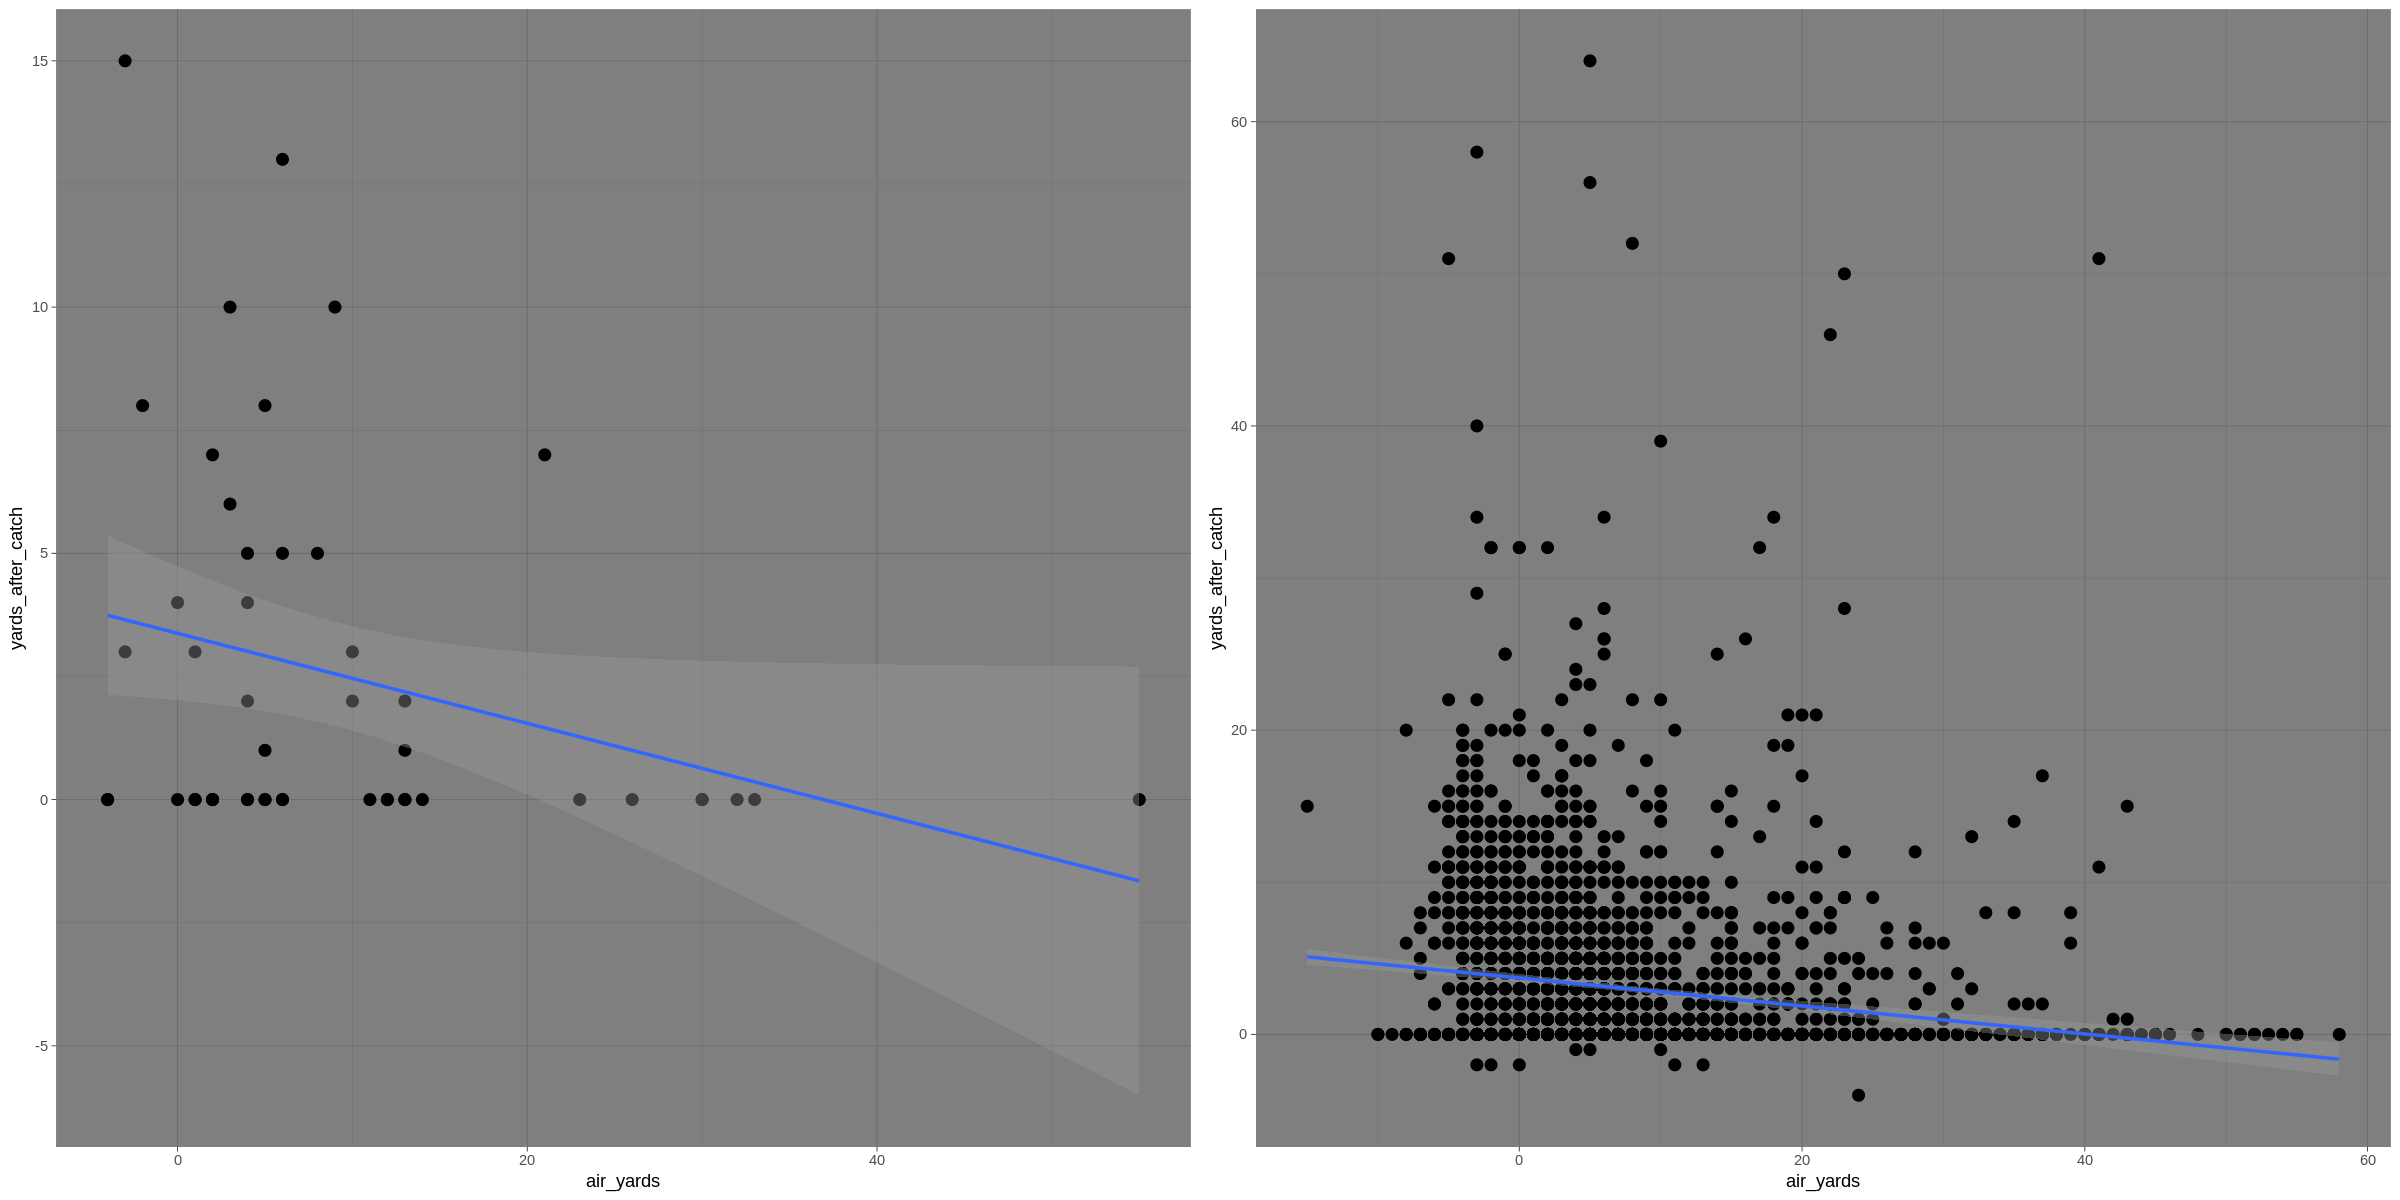

In [41]:
# Dallas
plot1 <- predict_wk3(my_teams[4], opponent_week_3[4])
plot2 <- predict_all(my_teams[4])

grid.arrange(plot1, plot2, ncol = 2)

### Las Vegas
The trend for Las Vegas vs. Carolina is actually slightly higher than for Las Vegas vs. All Opponents.

LV  vs.  CAR

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


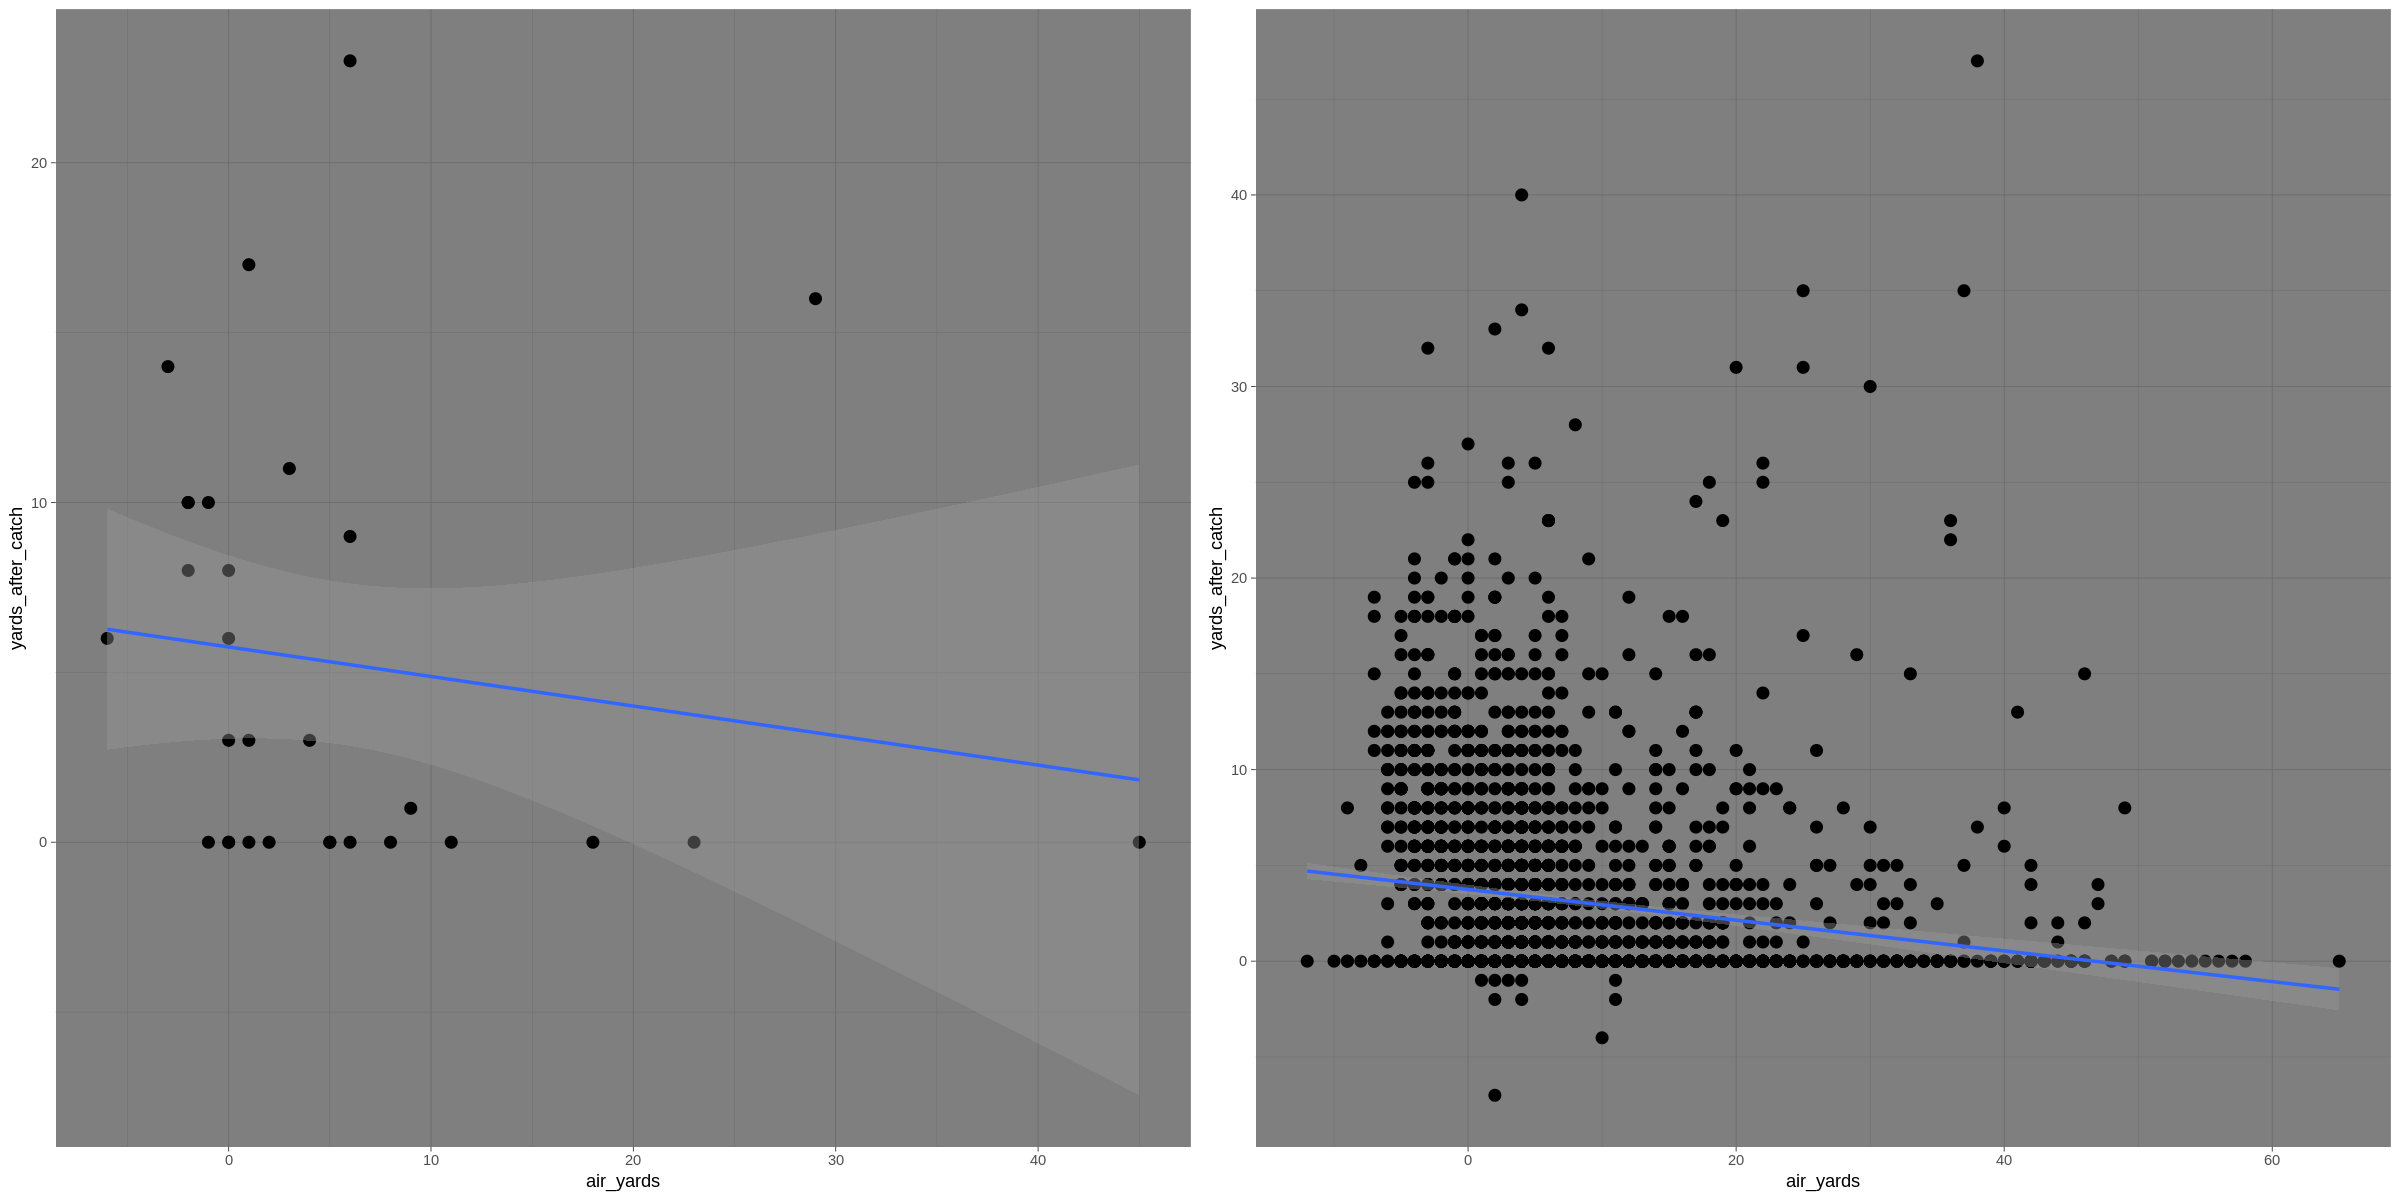

In [42]:
# Las Vegas
plot1 <- predict_wk3(my_teams[5], opponent_week_3[5])
plot2 <- predict_all(my_teams[5])

grid.arrange(plot1, plot2, ncol = 2)

### Rams
The Rams appear to throw a lot of screen passes and it looks like many of them have turned into solid gains for them.  The trend looks very similar against all opponents as it does against the 49ers, however, perhaps more flat.

LA  vs.  SF

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


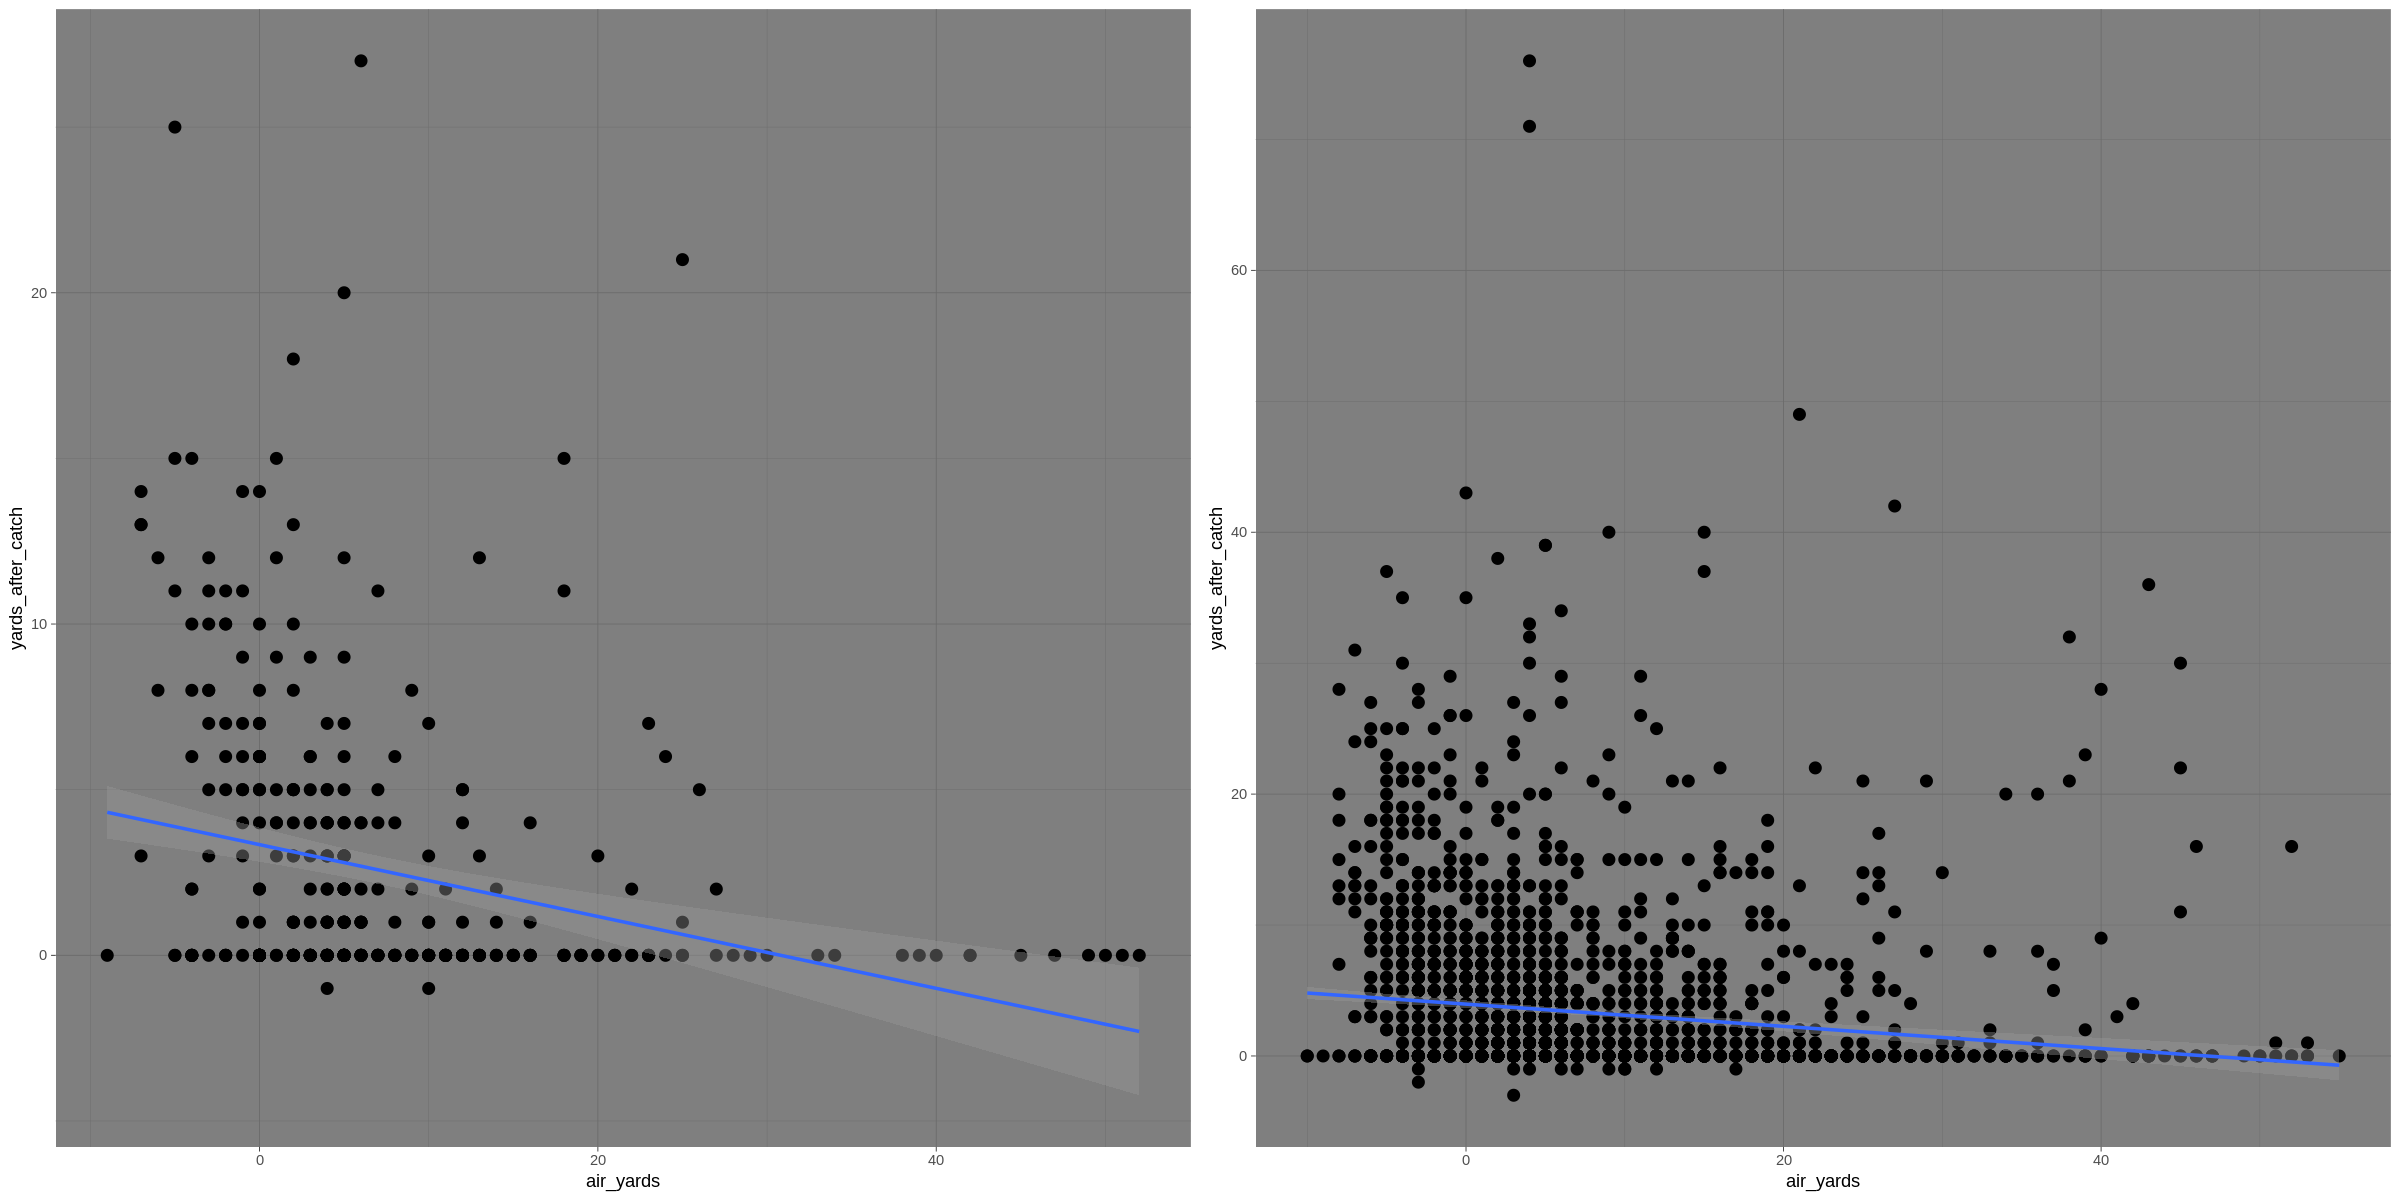

In [43]:
# Las Angeles Rams
plot1 <- predict_wk3(my_teams[6], opponent_week_3[6])
plot2 <- predict_all(my_teams[6])

grid.arrange(plot1, plot2, ncol = 2)

### Carolina
Carolina is the only team that has an upward trend.  That is drastically different from how they perform against all other teams, which would indicate they may be more successful in getting yards after the catch if they throw it longer than if they throw it short.

CAR  vs.  LV

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


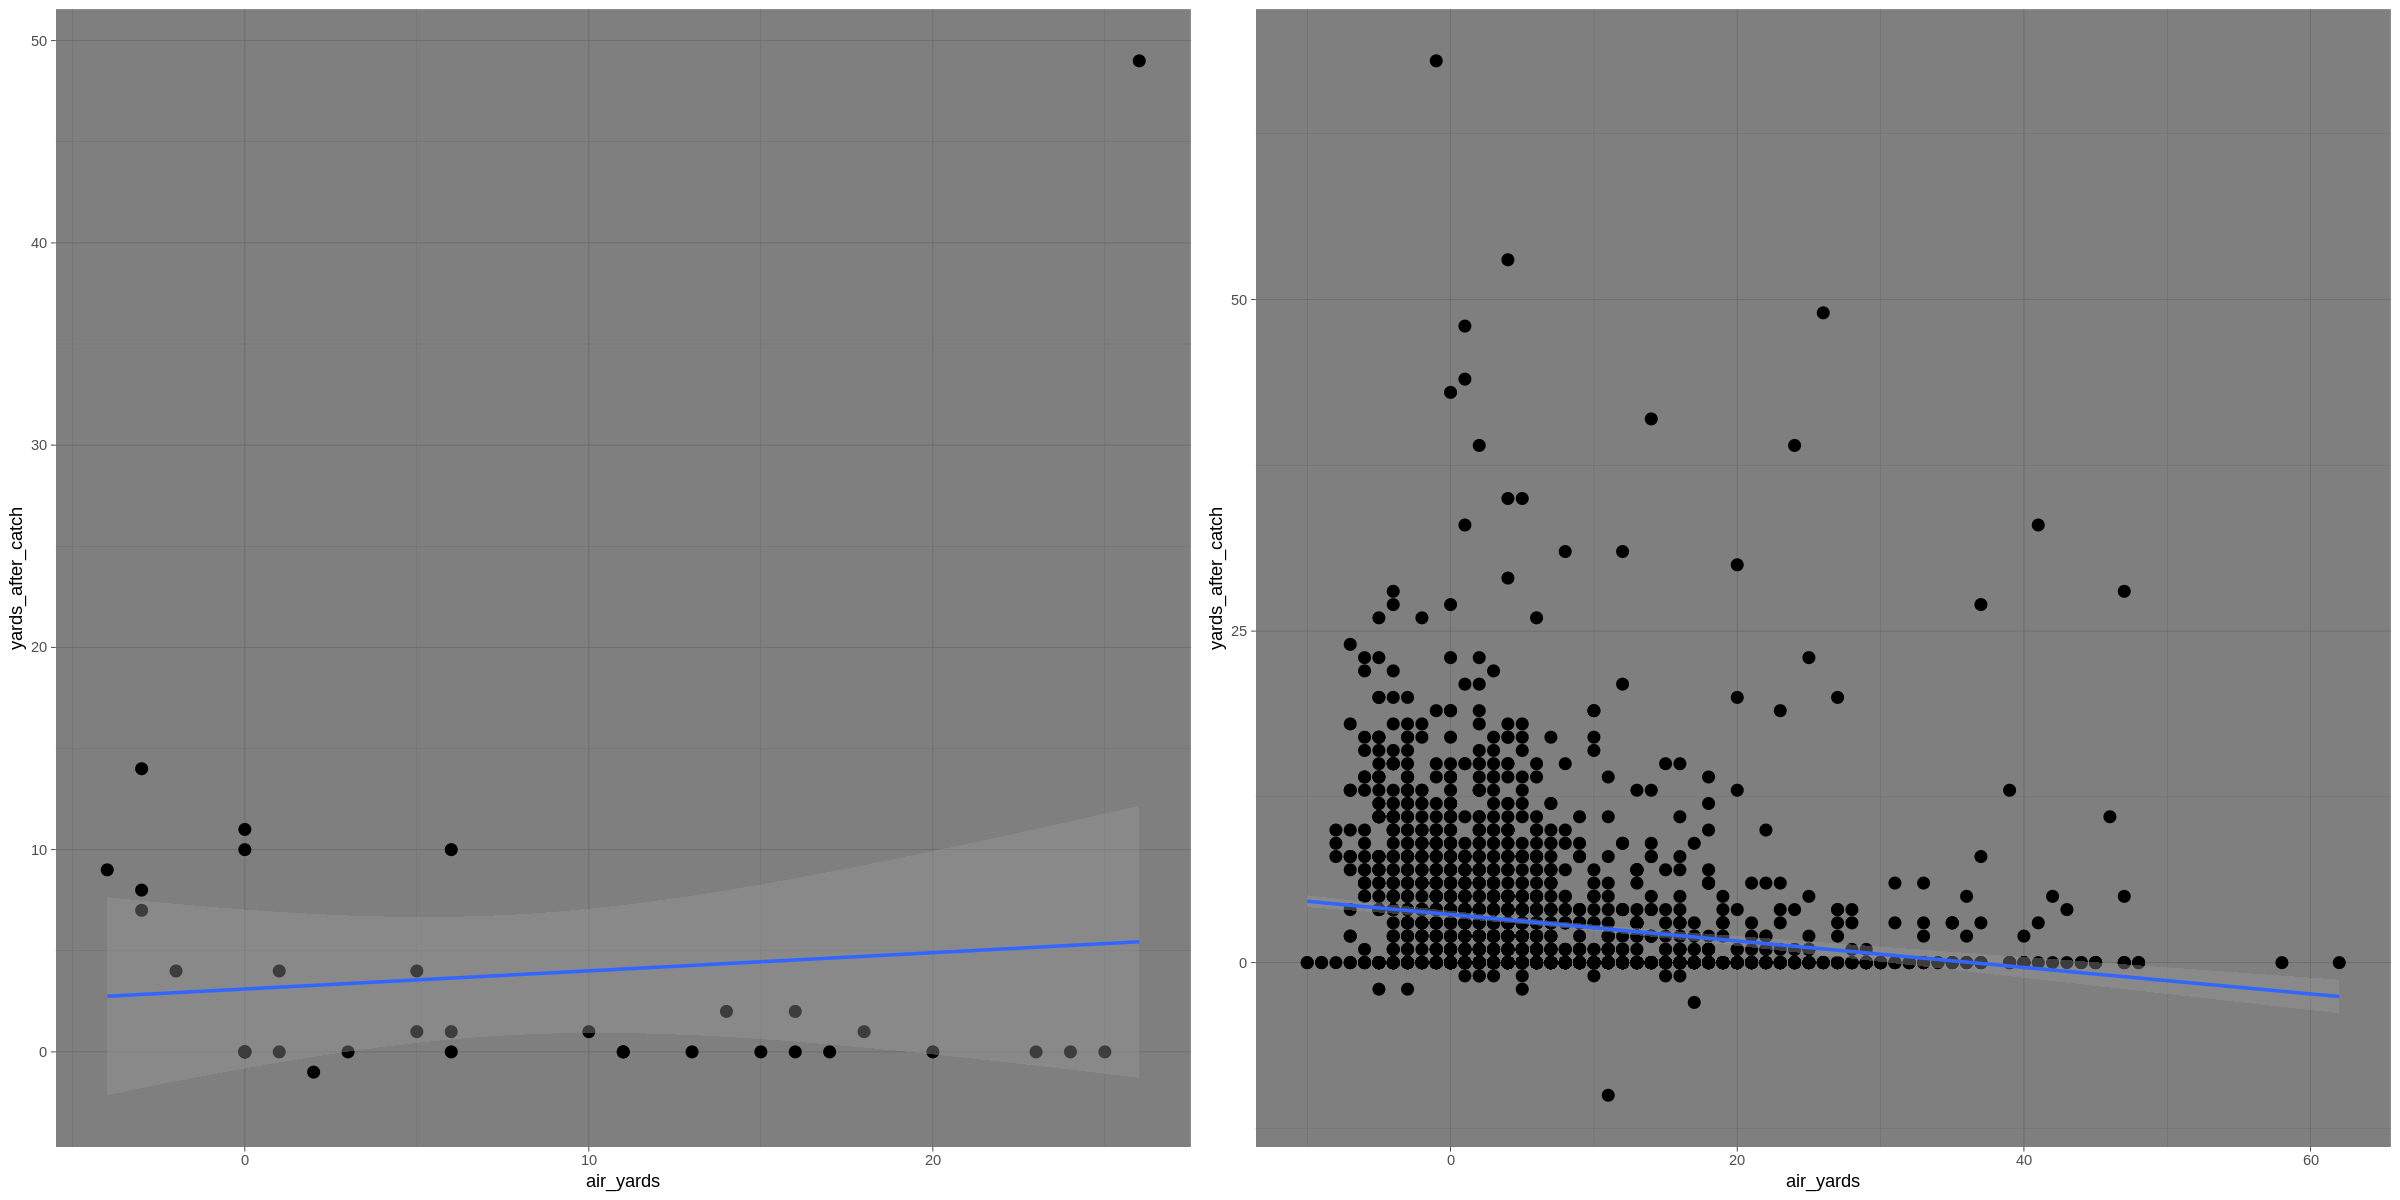

In [44]:
# Carolina
plot1 <- predict_wk3(my_teams[7], opponent_week_3[7])
plot2 <- predict_all(my_teams[7])

grid.arrange(plot1, plot2, ncol = 2)

### Detroit
Detroit's trendline looks fairly similar against Arizona as it does against all opponents, though maybe just a little steeper, indicating that they may not get as many yards after the catch as they would against other opponents.

DET  vs.  ARI

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


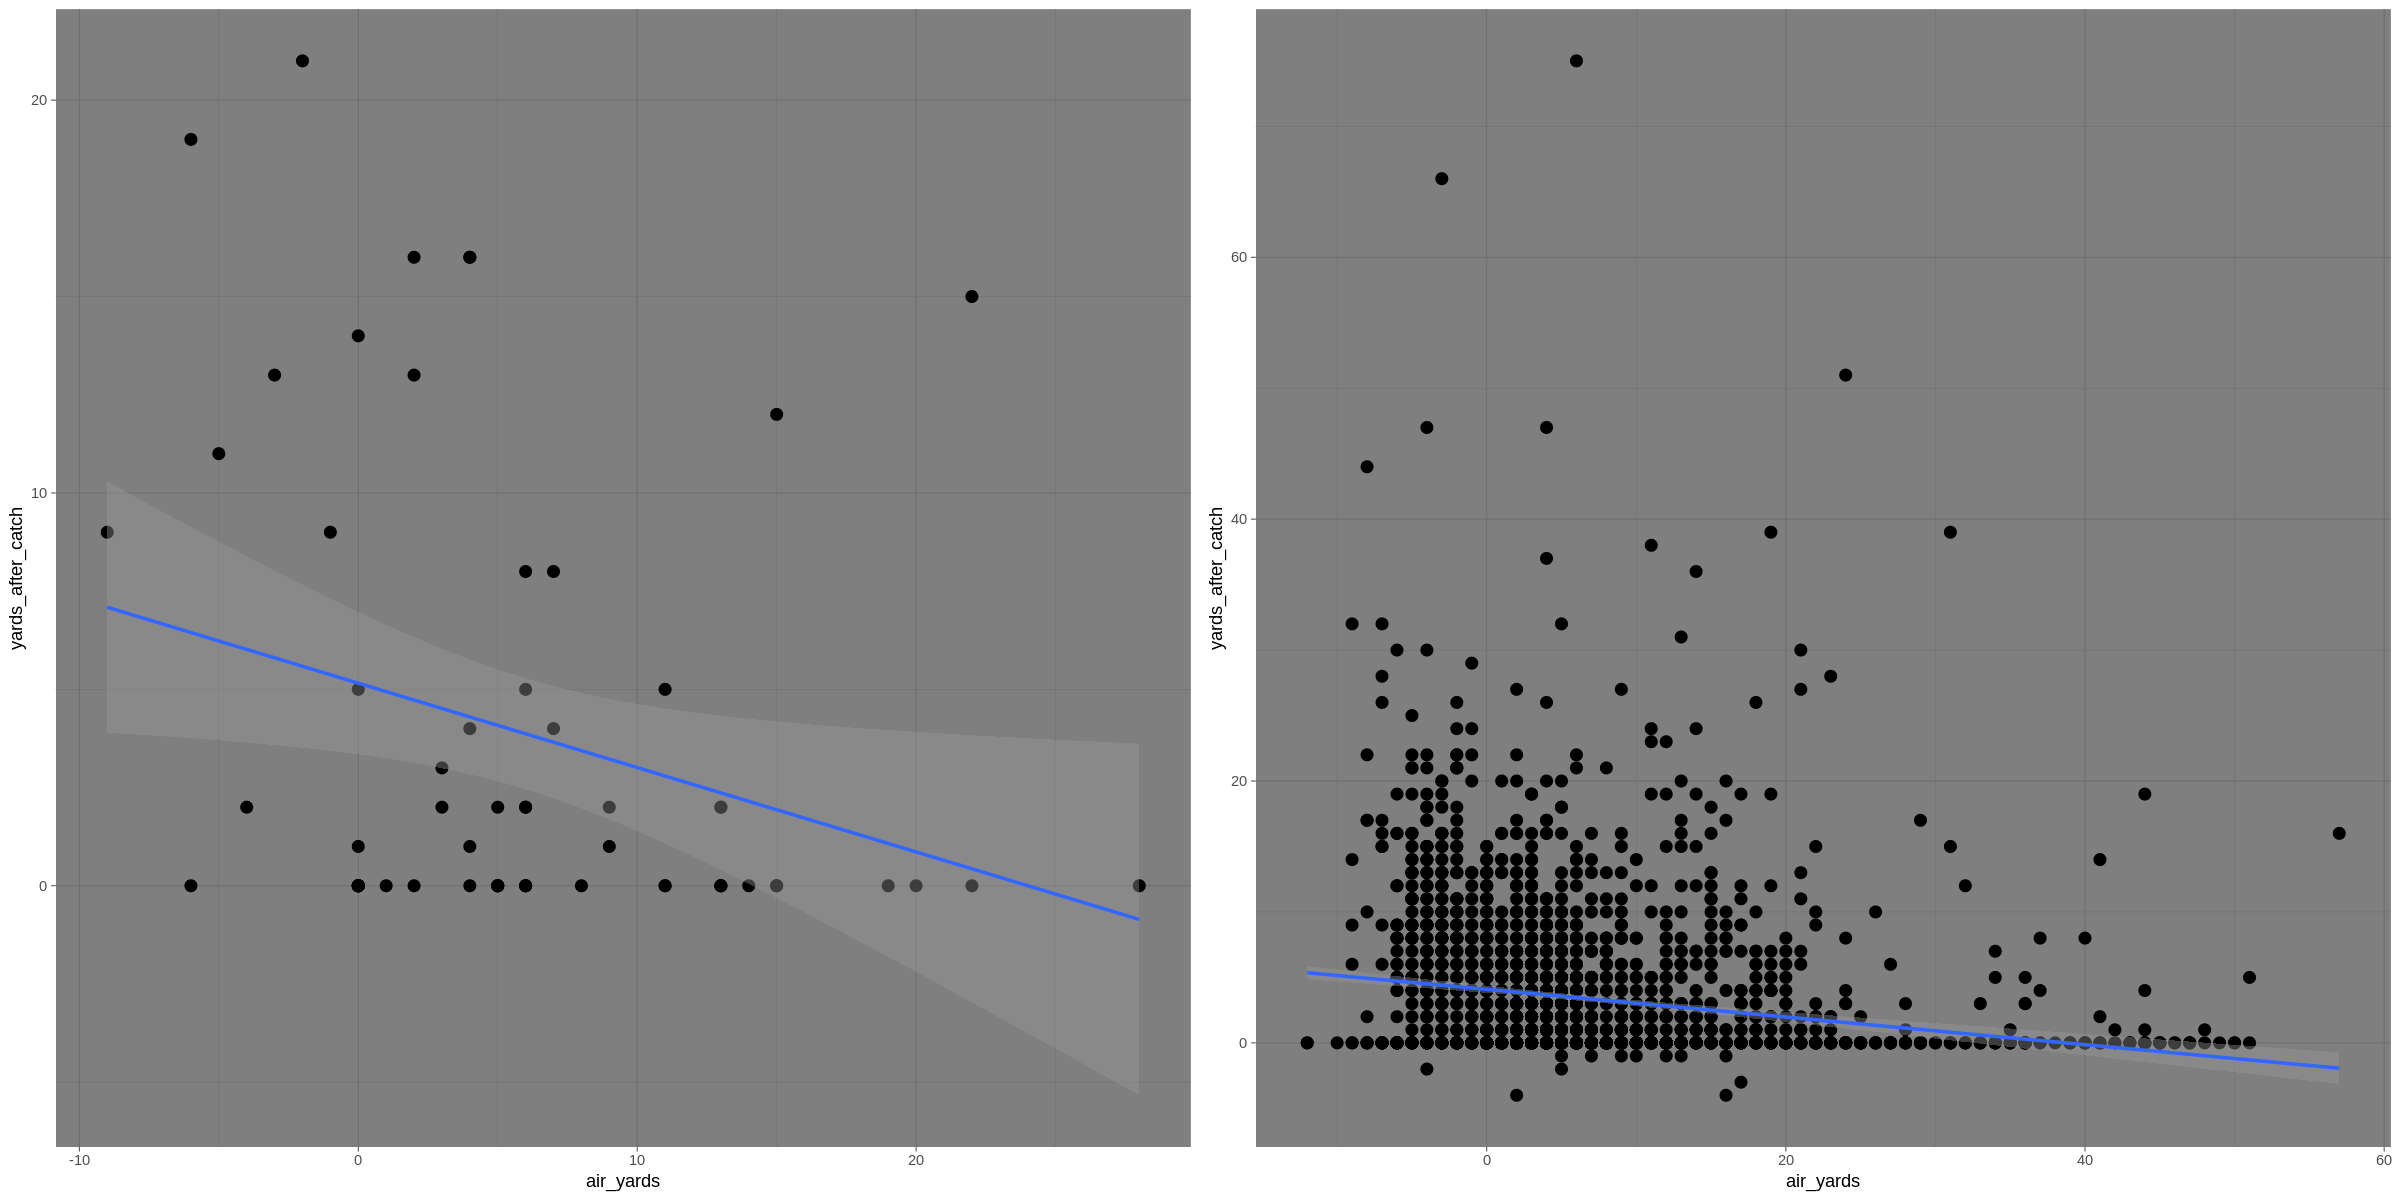

In [45]:
# Detroit
plot1 <- predict_wk3(my_teams[8], opponent_week_3[8])
plot2 <- predict_all(my_teams[8])

grid.arrange(plot1, plot2, ncol = 2)